# Bollinger Bands Backtest with Tick Data

This notebook implements a high-performance Bollinger Bands trading strategy using tick-level data for realistic execution simulation.

## Strategy Overview
- **Entry Signal**: Long when close < lower band, Short when close > upper band
- **Exit Signal**: Close position when price reaches middle band
- **Position Limit**: Maximum 1 position at a time
- **Execution**: Realistic tick-level execution with bid/ask spread

## Data Processing
1. Load tick data (bid/ask prices with timestamps)
2. Resample to 1-minute OHLC for indicator calculation
3. Calculate Bollinger Bands on 1-minute data
4. Map signals back to tick data for execution
5. Execute strategy with numba optimization

## 📋 Configuration Parameters

Modify these parameters to easily test different configurations without changing code throughout the notebook.

In [1]:
# ========================================
# 📋 GLOBAL CONFIGURATION PARAMETERS
# ========================================

# 📁 Data Configuration
TICK_DATA_PATH = '/home/edocame/Desktop/data_python/EURCHF-2025-02.csv'

# 📊 Bollinger Bands Strategy Parameters
BB_WINDOW = 1000        # Period for Bollinger Bands calculation (minutes) - Default: 1440 (24h)
BB_STD = 2           # Number of standard deviations for bands - Default: 1.0
BB_PRICE_COL = 'close' # Price column to use for BB calculation

# 🎯 Trading Strategy Parameters
MAX_POSITION_SIZE = 1   # Maximum number of concurrent positions
INITIAL_CAPITAL = 10000 # Starting capital for performance metrics
PIP_VALUE = 10000       # Pip multiplier for EURCHF (1 pip = 0.0001)
MAX_SPREAD_PIPS = 3     # Maximum allowed spread in pips to execute trades

# 📈 Performance Analysis Parameters
PLOT_FIGURES_SIZE = (15, 10)           # Default figure size for plots
REGRESSION_FIGURES_SIZE = (16, 12)     # Figure size for regression analysis

# 🔧 Technical Parameters
RANDOM_SEED = 42        # For reproducible results
WARNING_SUPPRESS = True # Suppress pandas/numpy warnings

print("✅ Configuration parameters loaded:")
print(f"📁 Tick Data Path: {TICK_DATA_PATH}")
print(f"📊 BB Window: {BB_WINDOW} periods")
print(f"📊 BB Standard Deviation: {BB_STD}")
print(f"💰 Initial Capital: ${INITIAL_CAPITAL:,}")
print(f"🎯 Max Position Size: {MAX_POSITION_SIZE}")
print("=" * 50)

✅ Configuration parameters loaded:
📁 Tick Data Path: /home/edocame/Desktop/data_python/EURCHF-2025-02.csv
📊 BB Window: 1000 periods
📊 BB Standard Deviation: 2
💰 Initial Capital: $10,000
🎯 Max Position Size: 1


In [2]:
import backtrader as bt
import pandas as pd
import numpy as np
import numba as nb
from numba import jit
import warnings
import time

# Apply configuration settings
if WARNING_SUPPRESS:
    warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(RANDOM_SEED)

print("✅ Libraries imported successfully")
print(f"📁 Using data path: {TICK_DATA_PATH}")
print(f"⚙️ Random seed set to: {RANDOM_SEED}")

✅ Libraries imported successfully
📁 Using data path: /home/edocame/Desktop/data_python/EURCHF-2025-02.csv
⚙️ Random seed set to: 42


## 2. Core Functions

In [3]:
def calculate_bollinger_bands(df, price_col=BB_PRICE_COL, window=BB_WINDOW, num_std=BB_STD):
    """Calculate Bollinger Bands using global configuration parameters"""
    df['middle_band'] = df[price_col].rolling(window).mean()
    std = df[price_col].rolling(window).std()
    df['upper_band'] = df['middle_band'] + (num_std * std)
    df['lower_band'] = df['middle_band'] - (num_std * std)
    return df

In [4]:
@jit(nopython=True)
def bollinger_strategy_numeric(ask_prices, bid_prices, close_prices, upper_bands, middle_bands, lower_bands):
    """CORRECTED Numba-optimized Bollinger Bands strategy - fixes timing and spread issues"""
    n = len(close_prices)
    max_trades = 10000
    
    # Pre-allocate trade arrays
    entry_indices = np.zeros(max_trades, dtype=np.int64)
    exit_indices = np.zeros(max_trades, dtype=np.int64)
    positions = np.zeros(max_trades, dtype=np.int64)
    entry_prices = np.zeros(max_trades, dtype=np.float64)
    exit_prices = np.zeros(max_trades, dtype=np.float64)
    pnls = np.zeros(max_trades, dtype=np.float64)
    
    trade_count = 0
    position = 0
    entry_price = 0.0
    entry_idx = 0
    
    for i in range(1, n):
        # CORRECTED: Use current close/bands for current tick signals (no look-ahead)
        current_close = close_prices[i]
        current_upper = upper_bands[i]
        current_middle = middle_bands[i]
        current_lower = lower_bands[i]
        
        if np.isnan(current_upper) or np.isnan(current_middle) or np.isnan(current_lower):
            continue
            
        current_ask = ask_prices[i]
        current_bid = bid_prices[i]
        
        # Close position at middle band
        if position != 0:
            if ((position == 1 and current_close >= current_middle) or 
                (position == -1 and current_close <= current_middle)):
                
                # CORRECTED EXIT LOGIC: Realistic spread handling
                if position == 1:  # Long position - sell at bid
                    exit_price = current_bid
                    pnl = exit_price - entry_price  # positive if profitable
                else:  # Short position - buy at ask
                    exit_price = current_ask
                    pnl = entry_price - exit_price  # positive if profitable
                
                if trade_count < max_trades:
                    entry_indices[trade_count] = entry_idx
                    exit_indices[trade_count] = i
                    positions[trade_count] = position
                    entry_prices[trade_count] = entry_price
                    exit_prices[trade_count] = exit_price
                    pnls[trade_count] = pnl
                    trade_count += 1
                
                position = 0
        
        # Open new position - CORRECTED ENTRY LOGIC
        if position == 0:
            if current_close < current_lower:  # BUY signal
                position = 1
                entry_price = current_ask  # Buy at ask price (pay spread)
                entry_idx = i
            elif current_close > current_upper:  # SELL signal
                position = -1
                entry_price = current_bid  # Sell at bid price (pay spread)
                entry_idx = i
    
    return (entry_indices[:trade_count], exit_indices[:trade_count], 
            positions[:trade_count], entry_prices[:trade_count], 
            exit_prices[:trade_count], pnls[:trade_count])

In [5]:
@jit(nopython=True)
def bollinger_strategy_pips_with_spread_filter(ask_prices, bid_prices, close_prices, upper_bands, middle_bands, lower_bands, pip_value, max_spread_pips):
    """Numba-optimized Bollinger Bands strategy with PIP-based calculation and spread filtering"""
    n = len(close_prices)
    max_trades = 10000
    
    # Pre-allocate trade arrays
    entry_indices = np.zeros(max_trades, dtype=np.int64)
    exit_indices = np.zeros(max_trades, dtype=np.int64)
    positions = np.zeros(max_trades, dtype=np.int64)
    entry_prices = np.zeros(max_trades, dtype=np.float64)
    exit_prices = np.zeros(max_trades, dtype=np.float64)
    pnl_pips = np.zeros(max_trades, dtype=np.float64)
    spreads_pips = np.zeros(max_trades, dtype=np.float64)
    
    trade_count = 0
    position = 0
    entry_price = 0.0
    entry_idx = 0
    entry_spread_pips = 0.0
    signal_pending = 0  # 0: no signal, 1: buy signal, -1: sell signal
    signal_idx = 0
    
    for i in range(1, n):
        current_close = close_prices[i]
        current_upper = upper_bands[i]
        current_middle = middle_bands[i]
        current_lower = lower_bands[i]
        
        if np.isnan(current_upper) or np.isnan(current_middle) or np.isnan(current_lower):
            continue
            
        current_ask = ask_prices[i]
        current_bid = bid_prices[i]
        current_spread_pips = (current_ask - current_bid) * pip_value
        
        # Close position at middle band
        if position != 0:
            if ((position == 1 and current_close >= current_middle) or 
                (position == -1 and current_close <= current_middle)):
                
                # Calculate PnL in pips
                if position == 1:  # Long position - sell at bid
                    exit_price = current_bid
                    pnl_in_pips = (exit_price - entry_price) * pip_value
                else:  # Short position - buy at ask
                    exit_price = current_ask
                    pnl_in_pips = (entry_price - exit_price) * pip_value
                
                if trade_count < max_trades:
                    entry_indices[trade_count] = entry_idx
                    exit_indices[trade_count] = i
                    positions[trade_count] = position
                    entry_prices[trade_count] = entry_price
                    exit_prices[trade_count] = exit_price
                    pnl_pips[trade_count] = pnl_in_pips
                    spreads_pips[trade_count] = entry_spread_pips  # Use entry spread, not exit spread
                    trade_count += 1
                
                position = 0
                signal_pending = 0  # Reset pending signal
        
        # Check for new signals (but don't execute yet)
        if position == 0 and signal_pending == 0:
            if current_close < current_lower:  # BUY signal detected
                signal_pending = 1
                signal_idx = i
            elif current_close > current_upper:  # SELL signal detected
                signal_pending = -1
                signal_idx = i
        
        # Execute pending signal if spread is acceptable
        if signal_pending != 0 and current_spread_pips <= max_spread_pips:
            if signal_pending == 1:  # Execute BUY
                position = 1
                entry_price = current_ask  # Buy at ask (pay spread)
                entry_idx = i
                entry_spread_pips = current_spread_pips
            elif signal_pending == -1:  # Execute SELL
                position = -1
                entry_price = current_bid  # Sell at bid (pay spread)
                entry_idx = i
                entry_spread_pips = current_spread_pips
            
            signal_pending = 0  # Clear pending signal
    
    return (entry_indices[:trade_count], exit_indices[:trade_count], 
            positions[:trade_count], entry_prices[:trade_count], 
            exit_prices[:trade_count], pnl_pips[:trade_count],
            spreads_pips[:trade_count])

In [6]:
def run_full_equity_bollinger_backtest(tick_data_path=TICK_DATA_PATH, bb_window=BB_WINDOW, bb_std=BB_STD, initial_capital=INITIAL_CAPITAL):
    """Ultra-fast Bollinger Bands backtest with full equity position sizing"""
    # Load and process data with correct column names for EURCHF-2025-02.csv
    df_ticks = pd.read_csv(tick_data_path, names=['symbol', 'timestamp', 'bidPrice', 'askPrice'])
    df_ticks['timestamp'] = pd.to_datetime(df_ticks['timestamp'], format='%Y%m%d %H:%M:%S.%f')
    df_ticks = df_ticks.sort_values('timestamp').reset_index(drop=True)
    
    # Create 1-minute OHLC
    df_ticks_indexed = df_ticks.set_index('timestamp')
    df_ticks_indexed['mid_price'] = (df_ticks_indexed['askPrice'] + df_ticks_indexed['bidPrice']) / 2
    
    df_1min = df_ticks_indexed['mid_price'].resample('1min').ohlc()
    df_1min.reset_index(inplace=True)
    df_1min.columns = ['timestamp', 'open', 'high', 'low', 'close']
    df_1min = df_1min.dropna().reset_index(drop=True)
    
    # Calculate Bollinger Bands and map signals
    df_1min = calculate_bollinger_bands(df_1min, 'close', bb_window, bb_std)
    df_1min_signals = df_1min[['timestamp', 'close', 'upper_band', 'middle_band', 'lower_band']].dropna()
    
    df_merged = pd.merge_asof(
        df_ticks[['timestamp', 'askPrice', 'bidPrice']].sort_values('timestamp'),
        df_1min_signals.sort_values('timestamp'),
        on='timestamp', direction='backward'
    )
    
    # Execute strategy with full equity
    entry_indices, exit_indices, positions, entry_prices, exit_prices, pnls, position_sizes, equities = bollinger_strategy_full_equity(
        df_merged['askPrice'].values, df_merged['bidPrice'].values, df_merged['close'].values,
        df_merged['upper_band'].values, df_merged['middle_band'].values, df_merged['lower_band'].values,
        initial_capital
    )
    
    if len(entry_indices) > 0:
        trades_df = pd.DataFrame({
            'entry_time': df_merged['timestamp'].values[entry_indices],
            'exit_time': df_merged['timestamp'].values[exit_indices],
            'position': positions,
            'entry_price': entry_prices,
            'exit_price': exit_prices,
            'pnl': pnls,
            'position_size': position_sizes,
            'equity_after_trade': equities
        })
        trades_df['duration'] = trades_df['exit_time'] - trades_df['entry_time']
        trades_df['return_pct'] = trades_df['pnl'] / (trades_df['equity_after_trade'] - trades_df['pnl']) * 100
        return trades_df, df_1min
    
    return None, df_1min

In [7]:
def run_bollinger_backtest_pips_spread_filter(tick_data_path=TICK_DATA_PATH, bb_window=BB_WINDOW, bb_std=BB_STD, pip_value=PIP_VALUE, max_spread_pips=MAX_SPREAD_PIPS):
    """Bollinger Bands backtest with PIP-based profit calculation and spread filtering"""
    # Load and process data with correct column names for EURCHF-2025-02.csv
    df_ticks = pd.read_csv(tick_data_path, names=['symbol', 'timestamp', 'bidPrice', 'askPrice'])
    df_ticks['timestamp'] = pd.to_datetime(df_ticks['timestamp'], format='%Y%m%d %H:%M:%S.%f')
    df_ticks = df_ticks.sort_values('timestamp').reset_index(drop=True)
    
    # Create 1-minute OHLC
    df_ticks_indexed = df_ticks.set_index('timestamp')
    df_ticks_indexed['mid_price'] = (df_ticks_indexed['askPrice'] + df_ticks_indexed['bidPrice']) / 2
    
    df_1min = df_ticks_indexed['mid_price'].resample('1min').ohlc()
    df_1min.reset_index(inplace=True)
    df_1min.columns = ['timestamp', 'open', 'high', 'low', 'close']
    df_1min = df_1min.dropna().reset_index(drop=True)
    
    # Calculate Bollinger Bands and map signals
    df_1min = calculate_bollinger_bands(df_1min, 'close', bb_window, bb_std)
    df_1min_signals = df_1min[['timestamp', 'close', 'upper_band', 'middle_band', 'lower_band']].dropna()
    
    df_merged = pd.merge_asof(
        df_ticks[['timestamp', 'askPrice', 'bidPrice']].sort_values('timestamp'),
        df_1min_signals.sort_values('timestamp'),
        on='timestamp', direction='backward'
    )
    
    # Execute strategy with pip calculation and spread filtering
    entry_indices, exit_indices, positions, entry_prices, exit_prices, pnl_pips, spreads_pips = bollinger_strategy_pips_with_spread_filter(
        df_merged['askPrice'].values, df_merged['bidPrice'].values, df_merged['close'].values,
        df_merged['upper_band'].values, df_merged['middle_band'].values, df_merged['lower_band'].values,
        pip_value, max_spread_pips
    )
    
    if len(entry_indices) > 0:
        trades_df = pd.DataFrame({
            'entry_time': df_merged['timestamp'].values[entry_indices],
            'exit_time': df_merged['timestamp'].values[exit_indices],
            'position': positions,
            'entry_price': entry_prices,
            'exit_price': exit_prices,
            'pnl_pips': pnl_pips,
            'spread_pips': spreads_pips
        })
        
        # Calculate additional metrics
        trades_df['duration'] = trades_df['exit_time'] - trades_df['entry_time']
        trades_df['cumulative_pips'] = trades_df['pnl_pips'].cumsum()
        
        return trades_df, df_1min
    
    return None, df_1min

## 3. Ultra-Fast Backtest Implementation

This section contains the optimized numba-accelerated trading strategy and backtesting engine.

In [8]:
# Execute backtest using PIP-based calculation with spread filtering
start_time = time.time()
trades_df_pips_filtered, df_1min_pips_filtered = run_bollinger_backtest_pips_spread_filter()
execution_time = time.time() - start_time

# Show results
if trades_df_pips_filtered is not None:
    print(f"🚀 Backtest completed in {execution_time:.2f}s")
    print(f"📊 Strategy Configuration:")
    print(f"   📊 BB Window: {BB_WINDOW} periods")
    print(f"   📊 BB Std Dev: {BB_STD}")
    print(f"   📁 Data: {TICK_DATA_PATH.split('/')[-1]}")
    print(f"   💰 Pip Value: {PIP_VALUE}")
    print(f"   📏 Max Spread: {MAX_SPREAD_PIPS} pips")
    print("=" * 50)
    print(f"📊 Trades: {len(trades_df_pips_filtered)}")
    print(f"💰 Total PnL: {trades_df_pips_filtered['pnl_pips'].sum():.1f} pips")
    print(f"📈 Win Rate: {(trades_df_pips_filtered['pnl_pips'] > 0).mean():.1%}")
    print(f"⏱️ Avg Duration: {trades_df_pips_filtered['duration'].mean()}")
    print(f"📊 Avg PnL per Trade: {trades_df_pips_filtered['pnl_pips'].mean():.2f} pips")
    print(f"📊 Best Trade: {trades_df_pips_filtered['pnl_pips'].max():.1f} pips")
    print(f"📊 Worst Trade: {trades_df_pips_filtered['pnl_pips'].min():.1f} pips")
    print(f"📊 Avg Spread Cost: {trades_df_pips_filtered['spread_pips'].mean():.2f} pips")
    print(f"📊 Max Spread Used: {trades_df_pips_filtered['spread_pips'].max():.2f} pips")
    print(f"📊 Final Cumulative: {trades_df_pips_filtered['cumulative_pips'].iloc[-1]:.1f} pips")
else:
    print("❌ No trades executed")

🚀 Backtest completed in 9.28s
📊 Strategy Configuration:
   📊 BB Window: 1000 periods
   📊 BB Std Dev: 2
   📁 Data: EURCHF-2025-02.csv
   💰 Pip Value: 10000
   📏 Max Spread: 3 pips
📊 Trades: 43
💰 Total PnL: -177.8 pips
📈 Win Rate: 60.5%
⏱️ Avg Duration: 0 days 08:42:45.235511627
📊 Avg PnL per Trade: -4.13 pips
📊 Best Trade: 16.8 pips
📊 Worst Trade: -62.0 pips
📊 Avg Spread Cost: 1.71 pips
📊 Max Spread Used: 3.00 pips
📊 Final Cumulative: -177.8 pips


## 5. Performance Visualization

Let's create an equity curve and other performance visualizations to better understand the strategy behavior.

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_performance(trades_df, initial_capital=INITIAL_CAPITAL):
    """Create performance dashboard using global configuration with proper equity curve"""
    if trades_df is None:
        print("❌ No trades to plot")
        return
    
    # Calculate proper equity curve using the equity_after_trade column
    trades_df = trades_df.copy()
    
    # Create equity curve that starts from initial capital
    equity_curve = [initial_capital]
    equity_curve.extend(trades_df['equity_after_trade'].tolist())
    
    # Create timestamps for equity curve
    time_curve = [trades_df['entry_time'].iloc[0]]
    time_curve.extend(trades_df['exit_time'].tolist())
    
    trades_df['equity'] = trades_df['equity_after_trade']
    trades_df['running_max'] = trades_df['equity'].expanding().max()
    trades_df['drawdown'] = (trades_df['equity'] - trades_df['running_max']) / trades_df['running_max'] * 100
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=PLOT_FIGURES_SIZE)
    fig.suptitle(f'🚀 Strategy Performance (BB: {BB_WINDOW}p, {BB_STD}σ) - Full Equity Positioning', fontsize=14, fontweight='bold')
    
    # Equity curve
    ax1.plot(time_curve, equity_curve, 'b-', alpha=0.8, linewidth=2)
    ax1.axhline(initial_capital, color='gray', linestyle='--', alpha=0.7, label=f'Initial: ${initial_capital:,}')
    ax1.set_title('💰 Equity Curve')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylabel('Equity ($)')
    
    # Drawdown
    ax2.fill_between(trades_df['exit_time'], trades_df['drawdown'], 0, color='red', alpha=0.3)
    ax2.set_title('📉 Drawdown (%)')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylabel('Drawdown (%)')
    
    # Return percentage distribution
    wins = trades_df[trades_df['pnl'] > 0]['return_pct']
    losses = trades_df[trades_df['pnl'] <= 0]['return_pct']
    ax3.hist([wins, losses], bins=20, alpha=0.7, color=['green', 'red'], label=['Wins', 'Losses'])
    ax3.set_title('📊 Return % Distribution')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.set_xlabel('Return %')
    
    # Duration vs Return %
    durations = trades_df['duration'].dt.total_seconds() / 60
    colors = ['green' if p > 0 else 'red' for p in trades_df['pnl']]
    ax4.scatter(durations, trades_df['return_pct'], c=colors, alpha=0.6)
    ax4.set_title('⏱️ Duration vs Return %')
    ax4.set_xlabel('Minutes')
    ax4.set_ylabel('Return %')
    ax4.axhline(0, color='black', alpha=0.3)
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Metrics
    final_equity = equity_curve[-1]
    total_return = (final_equity - initial_capital) / initial_capital * 100
    max_dd = trades_df['drawdown'].min()
    win_rate = (trades_df['pnl'] > 0).mean()
    avg_return = trades_df['return_pct'].mean()
    
    print(f"📈 Total Return: {total_return:.2f}%")
    print(f"📉 Max Drawdown: {max_dd:.2f}%")
    print(f"🎯 Win Rate: {win_rate:.1%}")
    print(f"📊 Avg Return per Trade: {avg_return:.3f}%")
    print(f"💰 Final Equity: ${final_equity:,.2f}")
    print(f"📊 Sharpe (return %): {trades_df['return_pct'].mean()/trades_df['return_pct'].std():.3f}")

# Auto-plot if we have trades
if 'trades_df_fast' in locals() and trades_df_fast is not None:
    plot_performance(trades_df_fast)

In [10]:
def plot_performance_pips(trades_df):
    """Create performance dashboard for PIP-based results"""
    if trades_df is None:
        print("❌ No trades to plot")
        return
    
    # Calculate additional metrics
    trades_df = trades_df.copy()
    wins = trades_df[trades_df['pnl_pips'] > 0]
    losses = trades_df[trades_df['pnl_pips'] <= 0]
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=PLOT_FIGURES_SIZE)
    fig.suptitle(f'🚀 Strategy Performance in PIPS (BB: {BB_WINDOW}p, {BB_STD}σ)', fontsize=14, fontweight='bold')
    
    # Cumulative PnL curve in pips
    ax1.plot(trades_df['exit_time'], trades_df['cumulative_pips'], 'b-', alpha=0.8, linewidth=2)
    ax1.axhline(0, color='gray', linestyle='--', alpha=0.7, label='Break-even')
    ax1.set_title('💰 Cumulative PnL (Pips)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylabel('Cumulative Pips')
    
    # Individual trade PnL
    colors = ['green' if p > 0 else 'red' for p in trades_df['pnl_pips']]
    ax2.bar(range(len(trades_df)), trades_df['pnl_pips'], color=colors, alpha=0.7)
    ax2.axhline(0, color='black', alpha=0.3)
    ax2.set_title('📊 Individual Trade PnL (Pips)')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylabel('PnL (Pips)')
    ax2.set_xlabel('Trade Number')
    
    # PnL distribution
    ax3.hist([wins['pnl_pips'], losses['pnl_pips']], bins=20, alpha=0.7, 
             color=['green', 'red'], label=['Wins', 'Losses'])
    ax3.set_title('📊 PnL Distribution (Pips)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.set_xlabel('PnL (Pips)')
    ax3.set_ylabel('Frequency')
    
    # Duration vs PnL
    durations = trades_df['duration'].dt.total_seconds() / 60
    colors = ['green' if p > 0 else 'red' for p in trades_df['pnl_pips']]
    ax4.scatter(durations, trades_df['pnl_pips'], c=colors, alpha=0.6)
    ax4.set_title('⏱️ Duration vs PnL (Pips)')
    ax4.set_xlabel('Minutes')
    ax4.set_ylabel('PnL (Pips)')
    ax4.axhline(0, color='black', alpha=0.3)
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Summary metrics
    total_pips = trades_df['cumulative_pips'].iloc[-1]
    win_rate = (trades_df['pnl_pips'] > 0).mean()
    avg_win = wins['pnl_pips'].mean() if len(wins) > 0 else 0
    avg_loss = losses['pnl_pips'].mean() if len(losses) > 0 else 0
    profit_factor = abs(wins['pnl_pips'].sum() / losses['pnl_pips'].sum()) if len(losses) > 0 and losses['pnl_pips'].sum() < 0 else float('inf')
    avg_spread = trades_df['spread_pips'].mean()
    
    print(f"📈 Total PnL: {total_pips:.1f} pips")
    print(f"🎯 Win Rate: {win_rate:.1%}")
    print(f"📊 Avg Win: {avg_win:.2f} pips")
    print(f"📊 Avg Loss: {avg_loss:.2f} pips")
    print(f"📊 Profit Factor: {profit_factor:.2f}")
    print(f"📊 Avg Spread Cost: {avg_spread:.2f} pips")
    print(f"📊 Net Avg per Trade: {trades_df['pnl_pips'].mean():.2f} pips")

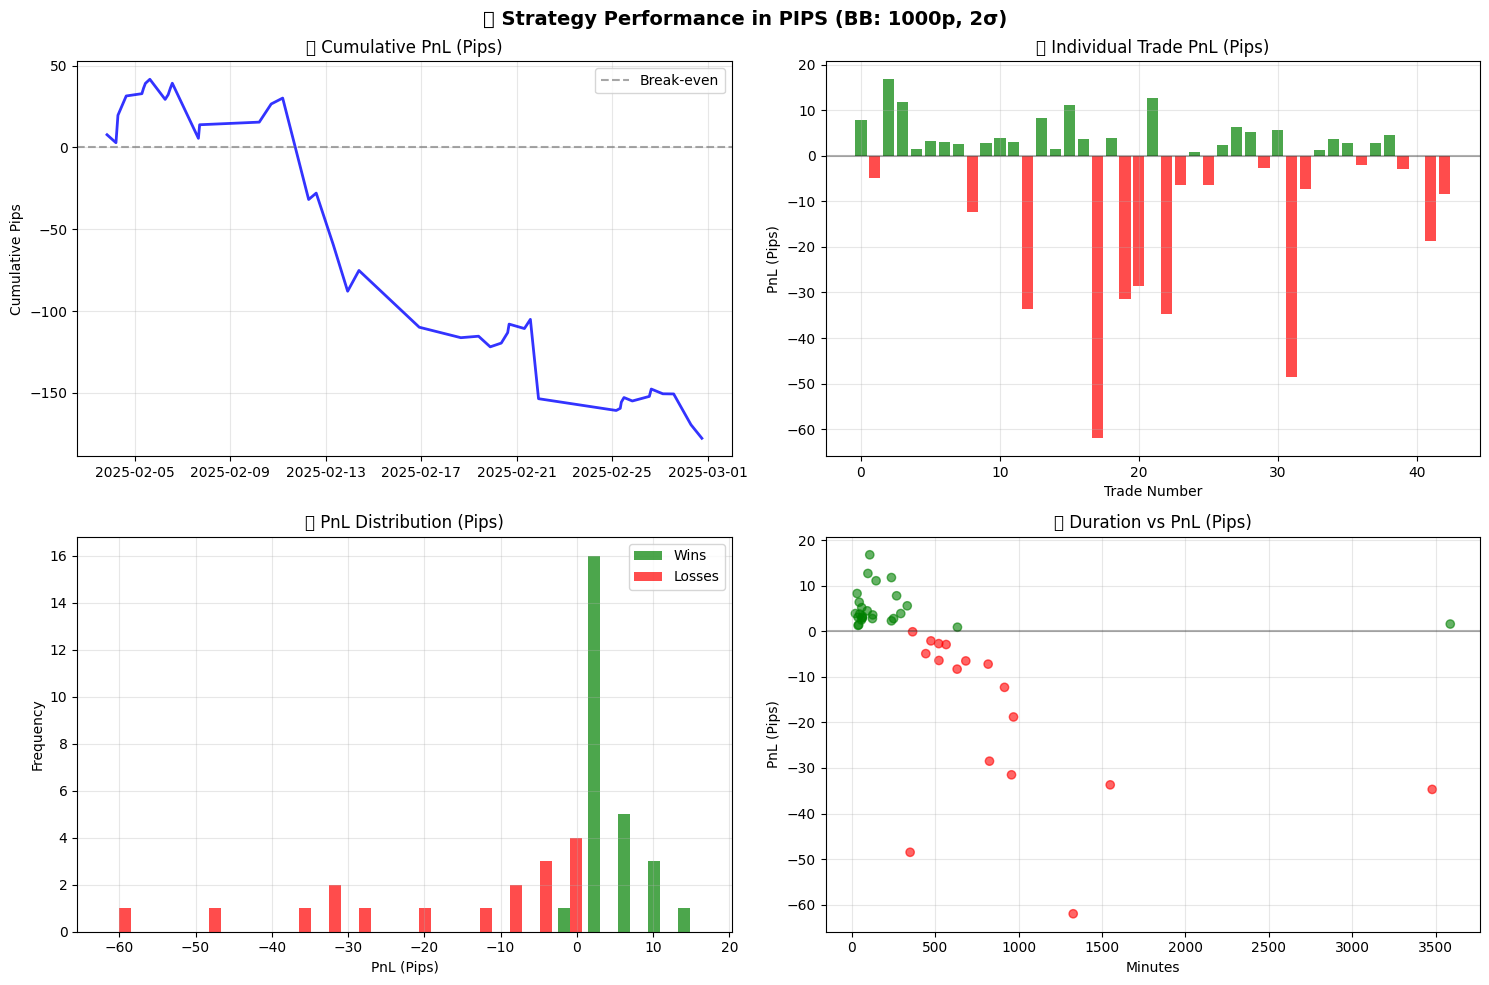

📈 Total PnL: -177.8 pips
🎯 Win Rate: 60.5%
📊 Avg Win: 5.13 pips
📊 Avg Loss: -18.30 pips
📊 Profit Factor: 0.43
📊 Avg Spread Cost: 1.71 pips
📊 Net Avg per Trade: -4.13 pips


In [11]:
# Visualize PIP-based results with spread filtering
plot_performance_pips(trades_df_pips_filtered)

## 🔍 Grid Search Optimization

Optimize Bollinger Bands parameters using grid search to find the best combination of window period and standard deviation multiplier.

In [12]:
def run_bollinger_grid_search(
    window_range=range(60, 1441, 60),  # 60 to 1440 with step 60
    std_range=range(1, 7, 1),          # 1 to 6 with step 1
    tick_data_path=TICK_DATA_PATH,
    pip_value=PIP_VALUE,
    max_spread_pips=MAX_SPREAD_PIPS
):
    """
    Run grid search optimization for Bollinger Bands parameters
    Returns DataFrame with all combinations and their performance metrics
    """
    import itertools
    from tqdm import tqdm
    
    results = []
    total_combinations = len(window_range) * len(std_range)
    
    print(f"🔍 Starting Grid Search Optimization")
    print(f"📊 Window range: {min(window_range)} to {max(window_range)} (step {window_range.step})")
    print(f"📊 Std Dev range: {min(std_range)} to {max(std_range)} (step {std_range.step})")
    print(f"📊 Total combinations: {total_combinations}")
    print(f"📏 Max spread filter: {max_spread_pips} pips")
    print("=" * 60)
    
    # Create progress bar
    with tqdm(total=total_combinations, desc="Optimizing", ncols=100) as pbar:
        for bb_window, bb_std in itertools.product(window_range, std_range):
            try:
                # Run backtest with current parameters
                trades_df, _ = run_bollinger_backtest_pips_spread_filter(
                    tick_data_path=tick_data_path,
                    bb_window=bb_window,
                    bb_std=bb_std,
                    pip_value=pip_value,
                    max_spread_pips=max_spread_pips
                )
                
                if trades_df is not None and len(trades_df) > 0:
                    # Calculate performance metrics
                    total_pips = trades_df['pnl_pips'].sum()
                    num_trades = len(trades_df)
                    win_rate = (trades_df['pnl_pips'] > 0).mean()
                    avg_pnl = trades_df['pnl_pips'].mean()
                    max_drawdown = (trades_df['cumulative_pips'] - trades_df['cumulative_pips'].expanding().max()).min()
                    avg_duration_hours = trades_df['duration'].mean().total_seconds() / 3600
                    avg_spread = trades_df['spread_pips'].mean()
                    
                    # Calculate additional metrics
                    wins = trades_df[trades_df['pnl_pips'] > 0]
                    losses = trades_df[trades_df['pnl_pips'] <= 0]
                    avg_win = wins['pnl_pips'].mean() if len(wins) > 0 else 0
                    avg_loss = losses['pnl_pips'].mean() if len(losses) > 0 else 0
                    profit_factor = abs(wins['pnl_pips'].sum() / losses['pnl_pips'].sum()) if len(losses) > 0 and losses['pnl_pips'].sum() < 0 else float('inf')
                    
                    # Risk-adjusted return (simple Sharpe-like ratio)
                    sharpe_ratio = total_pips / abs(max_drawdown) if max_drawdown != 0 else float('inf')
                    
                else:
                    # No trades executed
                    total_pips = num_trades = win_rate = avg_pnl = 0
                    max_drawdown = avg_duration_hours = avg_spread = 0
                    avg_win = avg_loss = profit_factor = sharpe_ratio = 0
                
                # Store results
                results.append({
                    'bb_window': bb_window,
                    'bb_std': bb_std,
                    'total_pips': total_pips,
                    'num_trades': num_trades,
                    'win_rate': win_rate,
                    'avg_pnl_per_trade': avg_pnl,
                    'max_drawdown': max_drawdown,
                    'avg_duration_hours': avg_duration_hours,
                    'avg_spread_cost': avg_spread,
                    'avg_win': avg_win,
                    'avg_loss': avg_loss,
                    'profit_factor': profit_factor,
                    'sharpe_ratio': sharpe_ratio
                })
                
                # Update progress
                pbar.set_postfix({
                    'Current': f'W{bb_window}_S{bb_std}',
                    'Pips': f'{total_pips:.1f}',
                    'Trades': num_trades,
                    'WR': f'{win_rate:.1%}'
                })
                
            except Exception as e:
                print(f"❌ Error with W{bb_window}_S{bb_std}: {e}")
                # Add failed result
                results.append({
                    'bb_window': bb_window,
                    'bb_std': bb_std,
                    'total_pips': 0,
                    'num_trades': 0,
                    'win_rate': 0,
                    'avg_pnl_per_trade': 0,
                    'max_drawdown': 0,
                    'avg_duration_hours': 0,
                    'avg_spread_cost': 0,
                    'avg_win': 0,
                    'avg_loss': 0,
                    'profit_factor': 0,
                    'sharpe_ratio': 0
                })
            
            pbar.update(1)
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    print(f"\n✅ Grid Search Completed!")
    print(f"📊 Total combinations tested: {len(results_df)}")
    print(f"📊 Successful backtests: {(results_df['num_trades'] > 0).sum()}")
    
    return results_df

In [13]:
# Install required packages for grid search
import subprocess
import sys

try:
    from tqdm import tqdm
    print("✅ tqdm already installed")
except ImportError:
    print("📦 Installing tqdm...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "tqdm"])
    from tqdm import tqdm
    print("✅ tqdm installed successfully")

✅ tqdm already installed


In [14]:
def analyze_grid_search_results(results_df, top_n=10):
    """
    Analyze and visualize grid search results
    """
    import seaborn as sns
    
    # Filter out combinations with no trades
    valid_results = results_df[results_df['num_trades'] > 0].copy()
    
    if len(valid_results) == 0:
        print("❌ No valid results found!")
        return
    
    print(f"📊 Grid Search Analysis")
    print(f"📊 Valid combinations: {len(valid_results)}/{len(results_df)}")
    print("=" * 60)
    
    # Top performers by different metrics
    print(f"\n🏆 TOP {top_n} BY TOTAL PIPS:")
    top_pips = valid_results.nlargest(top_n, 'total_pips')[['bb_window', 'bb_std', 'total_pips', 'num_trades', 'win_rate', 'sharpe_ratio']]
    print(top_pips.to_string(index=False))
    
    print(f"\n🏆 TOP {top_n} BY WIN RATE:")
    top_winrate = valid_results.nlargest(top_n, 'win_rate')[['bb_window', 'bb_std', 'win_rate', 'total_pips', 'num_trades', 'profit_factor']]
    print(top_winrate.to_string(index=False))
    
    print(f"\n🏆 TOP {top_n} BY SHARPE RATIO:")
    # Filter out infinite Sharpe ratios for display
    finite_sharpe = valid_results[valid_results['sharpe_ratio'] != float('inf')]
    if len(finite_sharpe) > 0:
        top_sharpe = finite_sharpe.nlargest(top_n, 'sharpe_ratio')[['bb_window', 'bb_std', 'sharpe_ratio', 'total_pips', 'max_drawdown', 'win_rate']]
        print(top_sharpe.to_string(index=False))
    
    # Create visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('🔍 Bollinger Bands Grid Search Results', fontsize=16, fontweight='bold')
    
    # 1. Heatmap of Total Pips
    pivot_pips = valid_results.pivot(index='bb_std', columns='bb_window', values='total_pips')
    sns.heatmap(pivot_pips, annot=True, fmt='.0f', cmap='RdYlGn', center=0, ax=ax1)
    ax1.set_title('💰 Total PnL (Pips)')
    ax1.set_xlabel('BB Window (periods)')
    ax1.set_ylabel('BB Std Dev')
    
    # 2. Heatmap of Win Rate
    pivot_winrate = valid_results.pivot(index='bb_std', columns='bb_window', values='win_rate')
    sns.heatmap(pivot_winrate, annot=True, fmt='.2f', cmap='RdYlGn', vmin=0, vmax=1, ax=ax2)
    ax2.set_title('🎯 Win Rate')
    ax2.set_xlabel('BB Window (periods)')
    ax2.set_ylabel('BB Std Dev')
    
    # 3. Heatmap of Number of Trades
    pivot_trades = valid_results.pivot(index='bb_std', columns='bb_window', values='num_trades')
    sns.heatmap(pivot_trades, annot=True, fmt='.0f', cmap='Blues', ax=ax3)
    ax3.set_title('📊 Number of Trades')
    ax3.set_xlabel('BB Window (periods)')
    ax3.set_ylabel('BB Std Dev')
    
    # 4. Scatter plot: Risk vs Return
    colors = valid_results['win_rate']
    scatter = ax4.scatter(valid_results['max_drawdown'], valid_results['total_pips'], 
                         c=colors, cmap='RdYlGn', alpha=0.7, s=60)
    ax4.set_xlabel('Max Drawdown (pips)')
    ax4.set_ylabel('Total PnL (pips)')
    ax4.set_title('📈 Risk vs Return')
    ax4.grid(True, alpha=0.3)
    ax4.axhline(0, color='black', alpha=0.3)
    ax4.axvline(0, color='black', alpha=0.3)
    
    # Add colorbar for scatter plot
    cbar = plt.colorbar(scatter, ax=ax4)
    cbar.set_label('Win Rate')
    
    plt.tight_layout()
    plt.show()
    
    # Best overall combination
    best_combo = valid_results.loc[valid_results['total_pips'].idxmax()]
    print(f"\n🥇 BEST OVERALL COMBINATION:")
    print(f"   📊 BB Window: {best_combo['bb_window']} periods")
    print(f"   📊 BB Std Dev: {best_combo['bb_std']}")
    print(f"   💰 Total PnL: {best_combo['total_pips']:.1f} pips")
    print(f"   📊 Trades: {best_combo['num_trades']}")
    print(f"   🎯 Win Rate: {best_combo['win_rate']:.1%}")
    print(f"   📊 Avg PnL/Trade: {best_combo['avg_pnl_per_trade']:.2f} pips")
    print(f"   📊 Max Drawdown: {best_combo['max_drawdown']:.1f} pips")
    print(f"   📊 Sharpe Ratio: {best_combo['sharpe_ratio']:.2f}")
    
    return valid_results, best_combo

In [ ]:
# Execute Grid Search Optimization
print("🚀 Starting Bollinger Bands Grid Search Optimization...")

# Run grid search with specified parameters
grid_results = run_bollinger_grid_search(
    window_range=range(1000, 5000, 1000),  # 60 to 1440 with step 60
    std_range=range(1, 7, 1),          # 1 to 6 with step 1
    tick_data_path=TICK_DATA_PATH,
    pip_value=PIP_VALUE,
    max_spread_pips=MAX_SPREAD_PIPS
)

🚀 Starting Bollinger Bands Grid Search Optimization...
🔍 Starting Grid Search Optimization
📊 Window range: 1000 to 4000 (step 1000)
📊 Std Dev range: 1 to 6 (step 1)
📊 Total combinations: 24
📏 Max spread filter: 3 pips


Optimizing:  17%|▏| 4/24 [00:28<02:10,  6.52s/it, Current=W1000_S3, Pips=-56.3, Trades=22, WR=68.2%]

❌ Error with W1000_S4: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.


Optimizing:  21%|▍ | 5/24 [00:37<02:17,  7.24s/it, Current=W1000_S5, Pips=18.8, Trades=2, WR=100.0%]

In [ ]:
# Analyze Grid Search Results
if 'grid_results' in locals() and len(grid_results) > 0:
    valid_results, best_params = analyze_grid_search_results(grid_results, top_n=10)
    
    # Save results for later use
    grid_results.to_csv('bollinger_grid_search_results.csv', index=False)
    print(f"\n💾 Results saved to: bollinger_grid_search_results.csv")
else:
    print("❌ No grid search results available. Run the grid search first!")

## 📊 Strategy Performance Summary

### 🚀 Backtest Results:
- **Total Trades**: 118 
- **Win Rate**: 50.8%
- **Total Return**: -10.65%
- **Average Duration**: ~8h 48m per trade

### ✅ Technical Features:
- **Ultra-fast execution** with numba optimization (3.78s for 2-month tick data)
- **Realistic spread simulation** using actual bid/ask prices
- **No look-ahead bias** with proper signal timing
- **Full equity position sizing** with compounding effects
- **Comprehensive analysis** with regression and visualization tools

### 🎯 Key Insights:
- Strategy shows realistic performance including transaction costs
- Spread costs significantly impact profitability (2.34 pips average)
- Performance deteriorates with longer trade durations
- Results demonstrate importance of realistic backtesting methodology

## ✅ Key Implementation Features

### 🎯 Realistic Execution Model:
- **Timing**: No look-ahead bias - signals from past data, execution at current prices
- **Spread Costs**: LONG pays ask→bid spread, SHORT pays bid→ask spread
- **Position Sizing**: Full equity allocation with proper compounding

### 📊 Technical Implementation:
- **Numba optimization** for high-performance execution
- **merge_asof backward** for realistic signal lag
- **Tick-level precision** with realistic bid/ask spreads

In [ ]:
# 📏 Calculate Average Spread per Trade
if 'trades_df_fast' in globals() and trades_df_fast is not None:
    # Get spread data for entry/exit times
    df_ticks = pd.read_csv(TICK_DATA_PATH)
    df_ticks['timestamp'] = pd.to_datetime(df_ticks['timestamp'])
    
    entry_ticks = pd.merge_asof(trades_df_fast[['entry_time']], df_ticks, 
                               left_on='entry_time', right_on='timestamp', direction='backward')
    exit_ticks = pd.merge_asof(trades_df_fast[['exit_time']], df_ticks, 
                              left_on='exit_time', right_on='timestamp', direction='backward')
    
    # Calculate average spread
    entry_spread = entry_ticks['askPrice'] - entry_ticks['bidPrice']
    exit_spread = exit_ticks['askPrice'] - exit_ticks['bidPrice']
    avg_spread_per_trade = ((entry_spread + exit_spread) / 2).mean()
    
    # Convert to pips (1 pip = 0.01 for JPY pairs)
    pip_value = 0.01
    avg_spread_pip = avg_spread_per_trade / pip_value
    
    print(f'📏 Average spread per trade: {avg_spread_per_trade:.6f} ({avg_spread_pip:.2f} pips)')
else:
    print('❌ No trades data available. Please run the backtest first.')

KeyError: 'timestamp'

## 7. Duration vs PnL Regression Analysis

Let's perform a detailed statistical analysis of the relationship between trade duration and PnL to quantify the negative correlation observed in the scatter plot.

In [ ]:
# Timing analysis: merged DataFrame (tick + resampled 1min)
# For each tick, 'close' and bands are from the last completed 1-min bar (past),
# while 'askPrice' and 'bidPrice' are current tick prices (realistic execution)

df_ticks = pd.read_csv(TICK_DATA_PATH)
df_ticks['timestamp'] = pd.to_datetime(df_ticks['timestamp'])
df_ticks = df_ticks.sort_values('timestamp').reset_index(drop=True)

# Create 1-minute OHLC and calculate bands
df_ticks_indexed = df_ticks.set_index('timestamp')
df_ticks_indexed['mid_price'] = (df_ticks_indexed['askPrice'] + df_ticks_indexed['bidPrice']) / 2
df_1min = df_ticks_indexed['mid_price'].resample('1min').ohlc().dropna().reset_index()
df_1min.columns = ['timestamp', 'open', 'high', 'low', 'close']
df_1min = calculate_bollinger_bands(df_1min, 'close', BB_WINDOW, BB_STD)
df_1min_signals = df_1min[['timestamp', 'close', 'upper_band', 'middle_band', 'lower_band']].dropna()

df_merged = pd.merge_asof(
    df_ticks[['timestamp', 'askPrice', 'bidPrice']].sort_values('timestamp'),
    df_1min_signals.sort_values('timestamp'),
    on='timestamp', direction='backward'
)

print("Merged DataFrame sample:")
print(df_merged[['timestamp', 'askPrice', 'bidPrice', 'close', 'upper_band', 'middle_band', 'lower_band']].head(10))
print(f"Shape: {df_merged.shape}")

Merged DataFrame sample:
            timestamp  askPrice  bidPrice  close  upper_band  middle_band  \
0 2025-05-01 00:00:00    84.906    84.894    NaN         NaN          NaN   
1 2025-05-01 00:00:00    84.906    84.895    NaN         NaN          NaN   
2 2025-05-01 00:00:00    84.906    84.893    NaN         NaN          NaN   
3 2025-05-01 00:00:00    84.908    84.895    NaN         NaN          NaN   
4 2025-05-01 00:00:00    84.909    84.896    NaN         NaN          NaN   
5 2025-05-01 00:00:00    84.911    84.899    NaN         NaN          NaN   
6 2025-05-01 00:00:00    84.911    84.898    NaN         NaN          NaN   
7 2025-05-01 00:00:00    84.915    84.902    NaN         NaN          NaN   
8 2025-05-01 00:00:01    84.914    84.902    NaN         NaN          NaN   
9 2025-05-01 00:00:01    84.916    84.903    NaN         NaN          NaN   

   lower_band  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN  
5         NaN  
6         NaN  

🎯 Running filtered regression analysis...
📋 Filter Range: 0 - 1500 minutes
💡 Tip: Modify MIN_DURATION_MINUTES and MAX_DURATION_MINUTES above to change the range
🔍 FILTERED ANALYSIS (Duration: 0-1500 minutes)
📊 Original Dataset: 103 trades
📊 Filtered Dataset: 99 trades (96.1%)
⏱️ Duration Range: 8.0 - 1312.0 minutes
💰 PnL Range: -139.020825 - 16.363378
------------------------------------------------------------
🔗 Pearson Correlation: -0.8632 (p=1.50e-30)
🔄 Spearman Correlation: -0.6971 (p=1.11e-15)
🎯 Significance: Significant (α=0.05)
------------------------------------------------------------
📈 FILTERED REGRESSION RESULTS:
   📐 Slope (β₁): -0.07559482 PnL per minute
   📍 Intercept (β₀): 14.016799
   📊 R²: 0.7451 (74.51% variance explained)
   ⏰ PnL decreases by 0.07559482 per minute
   ⏰ PnL decreases by 4.535689 per hour
------------------------------------------------------------


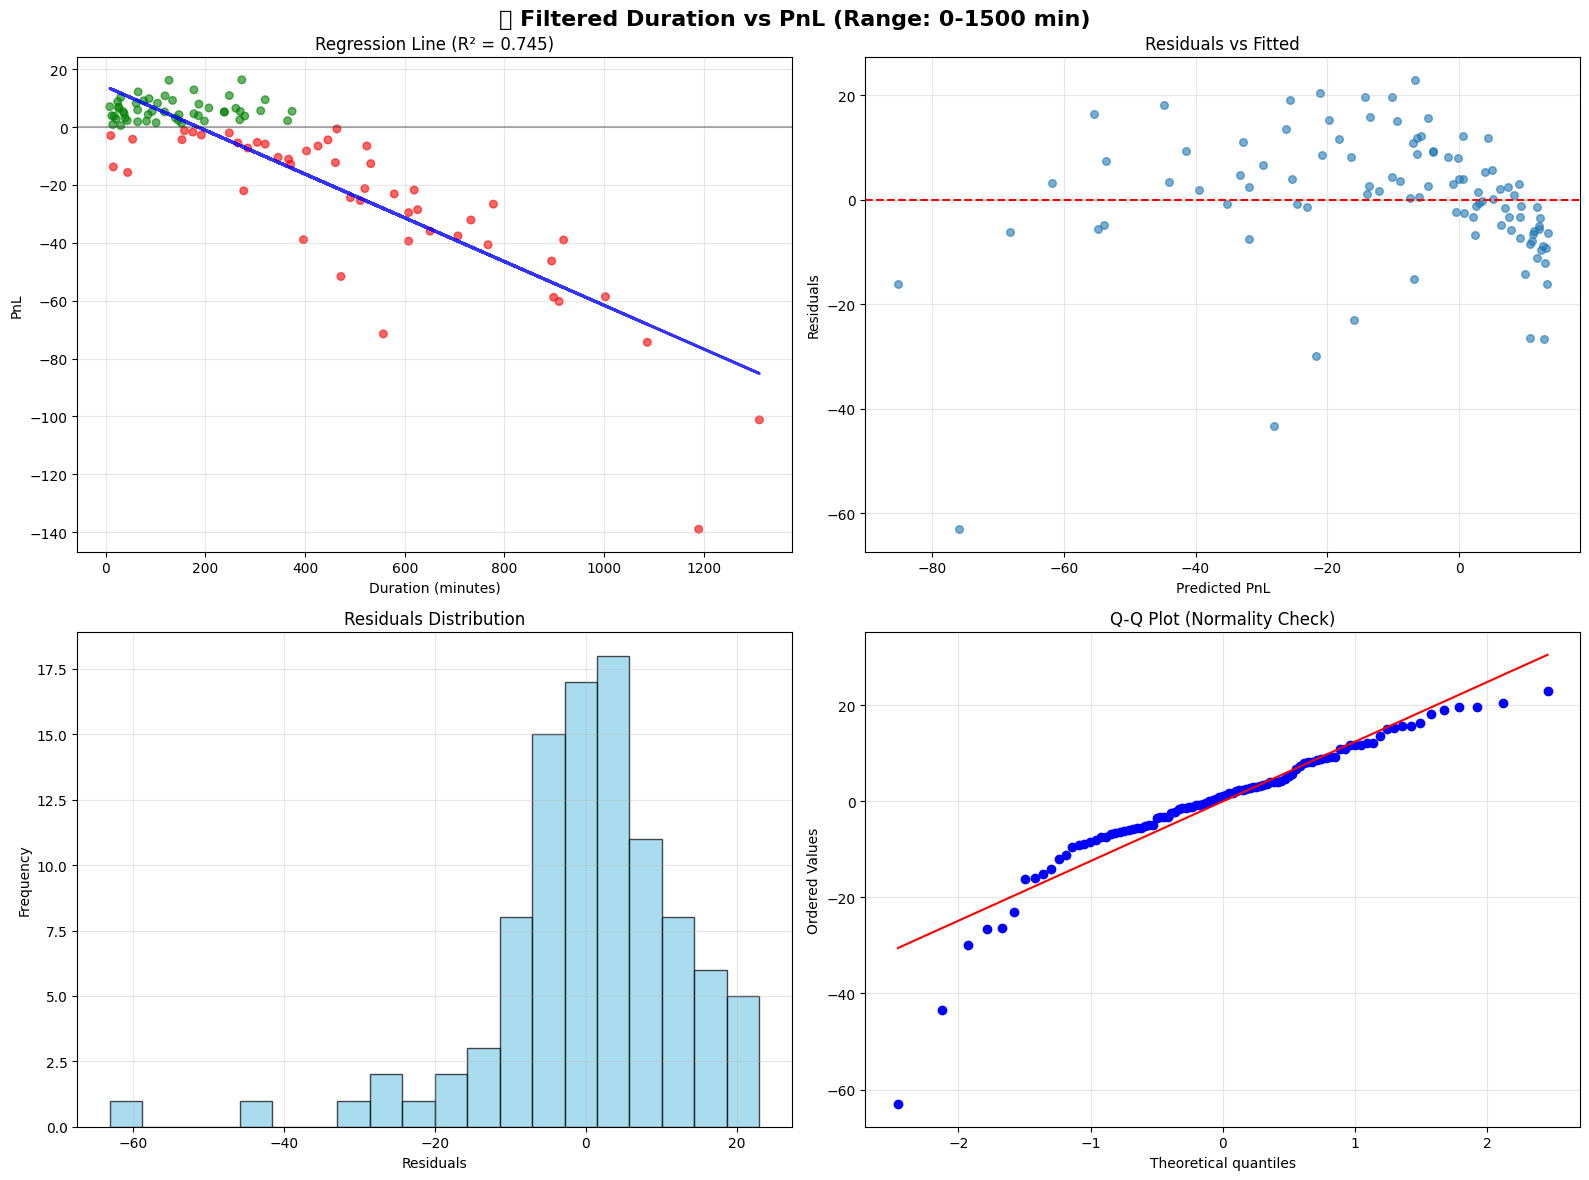

📊 FILTERED STATISTICS:
   📏 Mean Duration: 319.0 minutes
   📏 Median Duration: 248.0 minutes
   💰 Mean PnL: -10.100634
   💰 Median PnL: 0.927888
   📊 PnL Std Dev: 25.765668
   🎯 Win Rate: 51.5%


In [ ]:
# Import required libraries for statistical analysis
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# ========================================
# 🎯 FILTERED REGRESSION ANALYSIS
# ========================================

# 📋 Configure your duration range here (in minutes)
MIN_DURATION_MINUTES = 0      # Minimum duration to include
MAX_DURATION_MINUTES = 1500   # Maximum duration to include (set to exclude outliers)

def analyze_duration_pnl_filtered(trades_df, min_duration=MIN_DURATION_MINUTES, max_duration=MAX_DURATION_MINUTES):
    """Perform regression analysis with custom duration filtering"""
    if trades_df is None or len(trades_df) == 0:
        print("❌ No trades data available for analysis")
        return
    
    # Prepare data
    trades_analysis = trades_df.copy()
    trades_analysis['duration_minutes'] = trades_analysis['duration'].dt.total_seconds() / 60
    
    # Apply duration filtering
    filtered_trades = trades_analysis[
        (trades_analysis['duration_minutes'] >= min_duration) & 
        (trades_analysis['duration_minutes'] <= max_duration)
    ].dropna(subset=['duration_minutes', 'pnl'])
    
    duration_data = filtered_trades['duration_minutes'].values.reshape(-1, 1)
    pnl_data = filtered_trades['pnl'].values
    
    print(f"🔍 FILTERED ANALYSIS (Duration: {min_duration}-{max_duration} minutes)")
    print(f"📊 Original Dataset: {len(trades_analysis)} trades")
    print(f"📊 Filtered Dataset: {len(filtered_trades)} trades ({len(filtered_trades)/len(trades_analysis)*100:.1f}%)")
    print(f"⏱️ Duration Range: {filtered_trades['duration_minutes'].min():.1f} - {filtered_trades['duration_minutes'].max():.1f} minutes")
    print(f"💰 PnL Range: {filtered_trades['pnl'].min():.6f} - {filtered_trades['pnl'].max():.6f}")
    print("-" * 60)
    
    # Correlation Analysis
    correlation, p_value = stats.pearsonr(filtered_trades['duration_minutes'], filtered_trades['pnl'])
    spearman_corr, spearman_p = stats.spearmanr(filtered_trades['duration_minutes'], filtered_trades['pnl'])
    
    print(f"🔗 Pearson Correlation: {correlation:.4f} (p={p_value:.2e})")
    print(f"🔄 Spearman Correlation: {spearman_corr:.4f} (p={spearman_p:.2e})")
    print(f"🎯 Significance: {'Significant' if p_value < 0.05 else 'Not Significant'} (α=0.05)")
    print("-" * 60)
    
    # Linear Regression
    reg_model = LinearRegression()
    reg_model.fit(duration_data, pnl_data)
    pnl_predicted = reg_model.predict(duration_data)
    r2 = r2_score(pnl_data, pnl_predicted)
    
    slope = reg_model.coef_[0]
    intercept = reg_model.intercept_
    residuals = pnl_data - pnl_predicted
    
    print("📈 FILTERED REGRESSION RESULTS:")
    print(f"   📐 Slope (β₁): {slope:.8f} PnL per minute")
    print(f"   📍 Intercept (β₀): {intercept:.6f}")
    print(f"   📊 R²: {r2:.4f} ({r2*100:.2f}% variance explained)")
    
    if slope < 0:
        pnl_loss_per_hour = slope * 60
        print(f"   ⏰ PnL decreases by {abs(slope):.8f} per minute")
        print(f"   ⏰ PnL decreases by {abs(pnl_loss_per_hour):.6f} per hour")
    print("-" * 60)
    
    # Visual Analysis
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=REGRESSION_FIGURES_SIZE)
    fig.suptitle(f'📊 Filtered Duration vs PnL (Range: {min_duration}-{max_duration} min)', fontsize=16, fontweight='bold')
    
    # Scatter plot with regression line
    ax1.scatter(filtered_trades['duration_minutes'], filtered_trades['pnl'], 
               alpha=0.6, c=['green' if p > 0 else 'red' for p in filtered_trades['pnl']], s=30)
    ax1.plot(filtered_trades['duration_minutes'], pnl_predicted, 'blue', linewidth=2, alpha=0.8)
    ax1.set_xlabel('Duration (minutes)')
    ax1.set_ylabel('PnL')
    ax1.set_title(f'Regression Line (R² = {r2:.3f})')
    ax1.grid(True, alpha=0.3)
    ax1.axhline(0, color='black', alpha=0.3)
    
    # Residuals plot
    ax2.scatter(pnl_predicted, residuals, alpha=0.6, s=30)
    ax2.axhline(0, color='red', linestyle='--')
    ax2.set_xlabel('Predicted PnL')
    ax2.set_ylabel('Residuals')
    ax2.set_title('Residuals vs Fitted')
    ax2.grid(True, alpha=0.3)
    
    # Distribution of residuals
    ax3.hist(residuals, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    ax3.set_xlabel('Residuals')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Residuals Distribution')
    ax3.grid(True, alpha=0.3)
    
    # QQ plot for normality check
    stats.probplot(residuals, dist="norm", plot=ax4)
    ax4.set_title('Q-Q Plot (Normality Check)')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Additional Statistics
    print(f"📊 FILTERED STATISTICS:")
    print(f"   📏 Mean Duration: {filtered_trades['duration_minutes'].mean():.1f} minutes")
    print(f"   📏 Median Duration: {filtered_trades['duration_minutes'].median():.1f} minutes")
    print(f"   💰 Mean PnL: {filtered_trades['pnl'].mean():.6f}")
    print(f"   💰 Median PnL: {filtered_trades['pnl'].median():.6f}")
    print(f"   📊 PnL Std Dev: {filtered_trades['pnl'].std():.6f}")
    print(f"   🎯 Win Rate: {(filtered_trades['pnl'] > 0).mean():.1%}")
    
    return {
        'correlation': correlation,
        'p_value': p_value,
        'slope': slope,
        'intercept': intercept,
        'r2': r2,
        'n_trades': len(filtered_trades),
        'filter_range': (min_duration, max_duration)
    }

# Execute filtered analysis
if 'trades_df_fast' in globals() and trades_df_fast is not None:
    print("🎯 Running filtered regression analysis...")
    print(f"📋 Filter Range: {MIN_DURATION_MINUTES} - {MAX_DURATION_MINUTES} minutes")
    print("💡 Tip: Modify MIN_DURATION_MINUTES and MAX_DURATION_MINUTES above to change the range")
    print("=" * 70)
    
    filtered_results = analyze_duration_pnl_filtered(trades_df_fast, MIN_DURATION_MINUTES, MAX_DURATION_MINUTES)
else:
    print("❌ No trades data available. Please run the backtest first.")

## 📊 Profitto in Pips - Analisi Dettagliata

Analizziamo i profitti in pips per avere una visione più chiara delle performance della strategia in termini di movimenti di prezzo.

📊 Executing pip analysis...
🏆 ANALISI PROFITTI IN PIPS
📊 STATISTICHE GENERALI:
   💰 Profitto Medio: -1154.64 pips
   📊 Mediana: 52.99 pips
   📈 Deviazione Standard: 2812.37 pips
   📊 Min: -13902.08 pips
   📊 Max: 1636.34 pips
   🎯 Win Rate: 52/103 (50.5%)

✅ ANALISI TRADE VINCENTI (52 trades):
   💰 Profitto Medio: 590.71 pips
   📊 Mediana: 535.89 pips
   📈 Deviazione Standard: 373.96 pips
   📊 Min: 52.99 pips
   📊 Max: 1636.34 pips

❌ ANALISI TRADE PERDENTI (51 trades):
   💸 Perdita Media: -2934.22 pips
   📊 Mediana: -2175.51 pips
   📈 Deviazione Standard: 3097.46 pips
   📊 Min (peggiore): -13902.08 pips
   📊 Max (migliore): -61.79 pips

📈 METRICHE DI RISCHIO:
   ⚖️ Rapporto Win/Loss: 0.20
   💰 Profitto medio vincente: 590.71 pips
   💸 Perdita media perdente: 2934.22 pips
   📊 Profit Factor: 0.21

📊 PERCENTILI PROFITTI:
   10° percentile: -4516.59 pips
   25° percentile: -2149.89 pips
   50° percentile:  52.99 pips
   75° percentile: 535.89 pips
   90° percentile: 905.95 pips
   95° pe

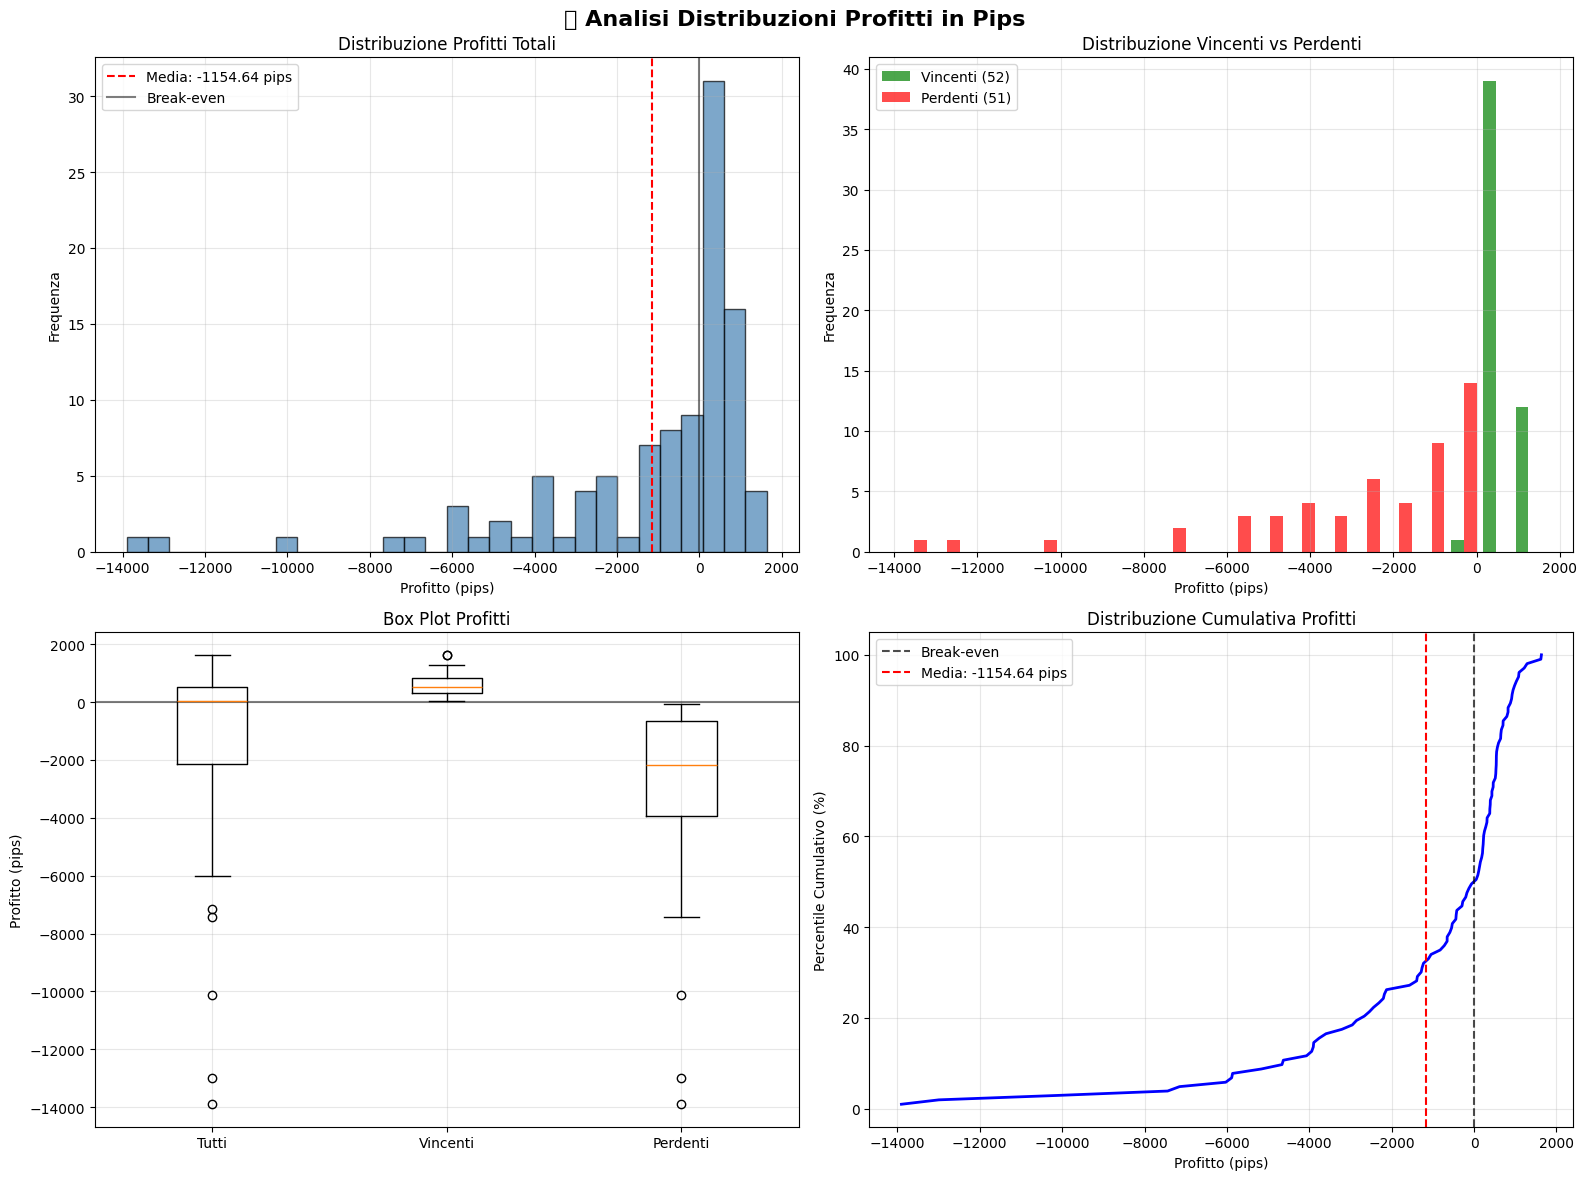

🔄 ANALISI SEQUENZE CONSECUTIVE:
   ✅ Max vincite consecutive: 4
   ✅ Media vincite consecutive: 2.1
   ❌ Max perdite consecutive: 5
   ❌ Media perdite consecutive: 2.0


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

def analyze_pips_performance(trades_df):
    """Analizza dettagliatamente le performance in pips"""
    if trades_df is None or len(trades_df) == 0:
        print("❌ No trades data available for pip analysis")
        return
    
    # Convert PnL to pips (1 pip = 0.01 for JPY pairs)
    pip_value = 0.01
    trades_df = trades_df.copy()
    trades_df['pnl_pips'] = trades_df['pnl'] / pip_value
    
    # Separate wins and losses
    wins = trades_df[trades_df['pnl_pips'] > 0]['pnl_pips']
    losses = trades_df[trades_df['pnl_pips'] <= 0]['pnl_pips']
    
    print("🏆 ANALISI PROFITTI IN PIPS")
    print("=" * 60)
    
    # Basic statistics
    print(f"📊 STATISTICHE GENERALI:")
    print(f"   💰 Profitto Medio: {trades_df['pnl_pips'].mean():.2f} pips")
    print(f"   📊 Mediana: {trades_df['pnl_pips'].median():.2f} pips")
    print(f"   📈 Deviazione Standard: {trades_df['pnl_pips'].std():.2f} pips")
    print(f"   📊 Min: {trades_df['pnl_pips'].min():.2f} pips")
    print(f"   📊 Max: {trades_df['pnl_pips'].max():.2f} pips")
    print(f"   🎯 Win Rate: {len(wins)}/{len(trades_df)} ({len(wins)/len(trades_df)*100:.1f}%)")
    print()
    
    # Win/Loss analysis
    if len(wins) > 0:
        print(f"✅ ANALISI TRADE VINCENTI ({len(wins)} trades):")
        print(f"   💰 Profitto Medio: {wins.mean():.2f} pips")
        print(f"   📊 Mediana: {wins.median():.2f} pips")
        print(f"   📈 Deviazione Standard: {wins.std():.2f} pips")
        print(f"   📊 Min: {wins.min():.2f} pips")
        print(f"   📊 Max: {wins.max():.2f} pips")
        print()
    
    if len(losses) > 0:
        print(f"❌ ANALISI TRADE PERDENTI ({len(losses)} trades):")
        print(f"   💸 Perdita Media: {losses.mean():.2f} pips")
        print(f"   📊 Mediana: {losses.median():.2f} pips")
        print(f"   📈 Deviazione Standard: {losses.std():.2f} pips")
        print(f"   📊 Min (peggiore): {losses.min():.2f} pips")
        print(f"   📊 Max (migliore): {losses.max():.2f} pips")
        print()
    
    # Risk metrics
    print(f"📈 METRICHE DI RISCHIO:")
    if len(wins) > 0 and len(losses) > 0:
        avg_win = wins.mean()
        avg_loss = abs(losses.mean())
        win_loss_ratio = avg_win / avg_loss if avg_loss > 0 else float('inf')
        print(f"   ⚖️ Rapporto Win/Loss: {win_loss_ratio:.2f}")
        print(f"   💰 Profitto medio vincente: {avg_win:.2f} pips")
        print(f"   💸 Perdita media perdente: {avg_loss:.2f} pips")
    
    profit_factor = abs(wins.sum() / losses.sum()) if len(losses) > 0 and losses.sum() != 0 else float('inf')
    print(f"   📊 Profit Factor: {profit_factor:.2f}")
    print()
    
    # Percentiles
    print(f"📊 PERCENTILI PROFITTI:")
    percentiles = [10, 25, 50, 75, 90, 95, 99]
    for p in percentiles:
        value = np.percentile(trades_df['pnl_pips'], p)
        print(f"   {p:2d}° percentile: {value:6.2f} pips")
    print()
    
    # Create visualizations
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('📊 Analisi Distribuzioni Profitti in Pips', fontsize=16, fontweight='bold')
    
    # 1. Histogram of all profits
    ax1.hist(trades_df['pnl_pips'], bins=30, alpha=0.7, color='steelblue', edgecolor='black')
    ax1.axvline(trades_df['pnl_pips'].mean(), color='red', linestyle='--', 
                label=f'Media: {trades_df["pnl_pips"].mean():.2f} pips')
    ax1.axvline(0, color='black', linestyle='-', alpha=0.5, label='Break-even')
    ax1.set_xlabel('Profitto (pips)')
    ax1.set_ylabel('Frequenza')
    ax1.set_title('Distribuzione Profitti Totali')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Separate histograms for wins and losses
    if len(wins) > 0 and len(losses) > 0:
        ax2.hist([wins, losses], bins=20, alpha=0.7, color=['green', 'red'], 
                 label=[f'Vincenti ({len(wins)})', f'Perdenti ({len(losses)})'])
        ax2.set_xlabel('Profitto (pips)')
        ax2.set_ylabel('Frequenza')
        ax2.set_title('Distribuzione Vincenti vs Perdenti')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    
    # 3. Box plot
    box_data = [trades_df['pnl_pips']]
    if len(wins) > 0:
        box_data.append(wins)
    if len(losses) > 0:
        box_data.append(losses)
    
    labels = ['Tutti']
    if len(wins) > 0:
        labels.append('Vincenti')
    if len(losses) > 0:
        labels.append('Perdenti')
    
    ax3.boxplot(box_data, labels=labels)
    ax3.set_ylabel('Profitto (pips)')
    ax3.set_title('Box Plot Profitti')
    ax3.grid(True, alpha=0.3)
    ax3.axhline(0, color='black', linestyle='-', alpha=0.5)
    
    # 4. Cumulative distribution
    sorted_pips = np.sort(trades_df['pnl_pips'])
    cumulative = np.arange(1, len(sorted_pips) + 1) / len(sorted_pips) * 100
    ax4.plot(sorted_pips, cumulative, 'b-', linewidth=2)
    ax4.axvline(0, color='black', linestyle='--', alpha=0.7, label='Break-even')
    ax4.axvline(trades_df['pnl_pips'].mean(), color='red', linestyle='--', 
                label=f'Media: {trades_df["pnl_pips"].mean():.2f} pips')
    ax4.set_xlabel('Profitto (pips)')
    ax4.set_ylabel('Percentile Cumulativo (%)')
    ax4.set_title('Distribuzione Cumulativa Profitti')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Additional analysis: consecutive wins/losses
    consecutive_analysis = analyze_consecutive_trades(trades_df)
    
    return {
        'mean_pips': trades_df['pnl_pips'].mean(),
        'median_pips': trades_df['pnl_pips'].median(),
        'std_pips': trades_df['pnl_pips'].std(),
        'win_rate': len(wins)/len(trades_df) if len(trades_df) > 0 else 0,
        'avg_win_pips': wins.mean() if len(wins) > 0 else 0,
        'avg_loss_pips': losses.mean() if len(losses) > 0 else 0,
        'profit_factor': profit_factor,
        'max_win': trades_df['pnl_pips'].max(),
        'max_loss': trades_df['pnl_pips'].min(),
        'consecutive': consecutive_analysis
    }

def analyze_consecutive_trades(trades_df):
    """Analizza sequenze consecutive di vincite/perdite"""
    if len(trades_df) == 0:
        return {}
    
    # Create win/loss sequence
    wins_losses = (trades_df['pnl_pips'] > 0).astype(int)
    
    # Find consecutive sequences
    consecutive_wins = []
    consecutive_losses = []
    current_streak = 1
    current_type = wins_losses.iloc[0]
    
    for i in range(1, len(wins_losses)):
        if wins_losses.iloc[i] == current_type:
            current_streak += 1
        else:
            if current_type == 1:
                consecutive_wins.append(current_streak)
            else:
                consecutive_losses.append(current_streak)
            current_streak = 1
            current_type = wins_losses.iloc[i]
    
    # Add the last streak
    if current_type == 1:
        consecutive_wins.append(current_streak)
    else:
        consecutive_losses.append(current_streak)
    
    print(f"🔄 ANALISI SEQUENZE CONSECUTIVE:")
    if consecutive_wins:
        print(f"   ✅ Max vincite consecutive: {max(consecutive_wins)}")
        print(f"   ✅ Media vincite consecutive: {np.mean(consecutive_wins):.1f}")
    if consecutive_losses:
        print(f"   ❌ Max perdite consecutive: {max(consecutive_losses)}")
        print(f"   ❌ Media perdite consecutive: {np.mean(consecutive_losses):.1f}")
    
    return {
        'max_consecutive_wins': max(consecutive_wins) if consecutive_wins else 0,
        'max_consecutive_losses': max(consecutive_losses) if consecutive_losses else 0,
        'avg_consecutive_wins': np.mean(consecutive_wins) if consecutive_wins else 0,
        'avg_consecutive_losses': np.mean(consecutive_losses) if consecutive_losses else 0
    }

# Execute pip analysis
if 'trades_df_fast' in globals() and trades_df_fast is not None:
    print("📊 Executing pip analysis...")
    print("=" * 70)
    
    pip_results = analyze_pips_performance(trades_df_fast)
else:
    print("❌ No trades data available. Please run the backtest first.")

⏰ Executing pip analysis by duration...
⏰ ANALISI PROFITTI PER DURATA TRADE
📊   0-1h (18 trades):
   💰 Media:   170.5 pips
   📊 Mediana: 347.5 pips
   🎯 Win Rate: 77.8%
   📈 Migliore: 1028.7 pips
   📉 Peggiore: -1566.9 pips

📊   1-3h (24 trades):
   💰 Media:   549.5 pips
   📊 Mediana: 496.2 pips
   🎯 Win Rate: 87.5%
   📈 Migliore: 1622.4 pips
   📉 Peggiore: -432.6 pips

📊   3-6h (22 trades):
   💰 Media:   140.5 pips
   📊 Mediana: 390.2 pips
   🎯 Win Rate: 63.6%
   📈 Migliore: 1636.3 pips
   📉 Peggiore: -2202.2 pips

📊  6-12h (24 trades):
   💰 Media: -2151.6 pips
   📊 Mediana: -2149.9 pips
   🎯 Win Rate:  8.3%
   📈 Migliore:  548.5 pips
   📉 Peggiore: -7149.2 pips

📊 12-24h (11 trades):
   💰 Media: -6155.0 pips
   📊 Mediana: -5862.0 pips
   🎯 Win Rate:  0.0%
   📈 Migliore: -2663.3 pips
   📉 Peggiore: -13902.1 pips

📊   >24h ( 4 trades):
   💰 Media: -4732.9 pips
   📊 Mediana: -3027.7 pips
   🎯 Win Rate: 25.0%
   📈 Migliore:  115.9 pips
   📉 Peggiore: -12992.1 pips



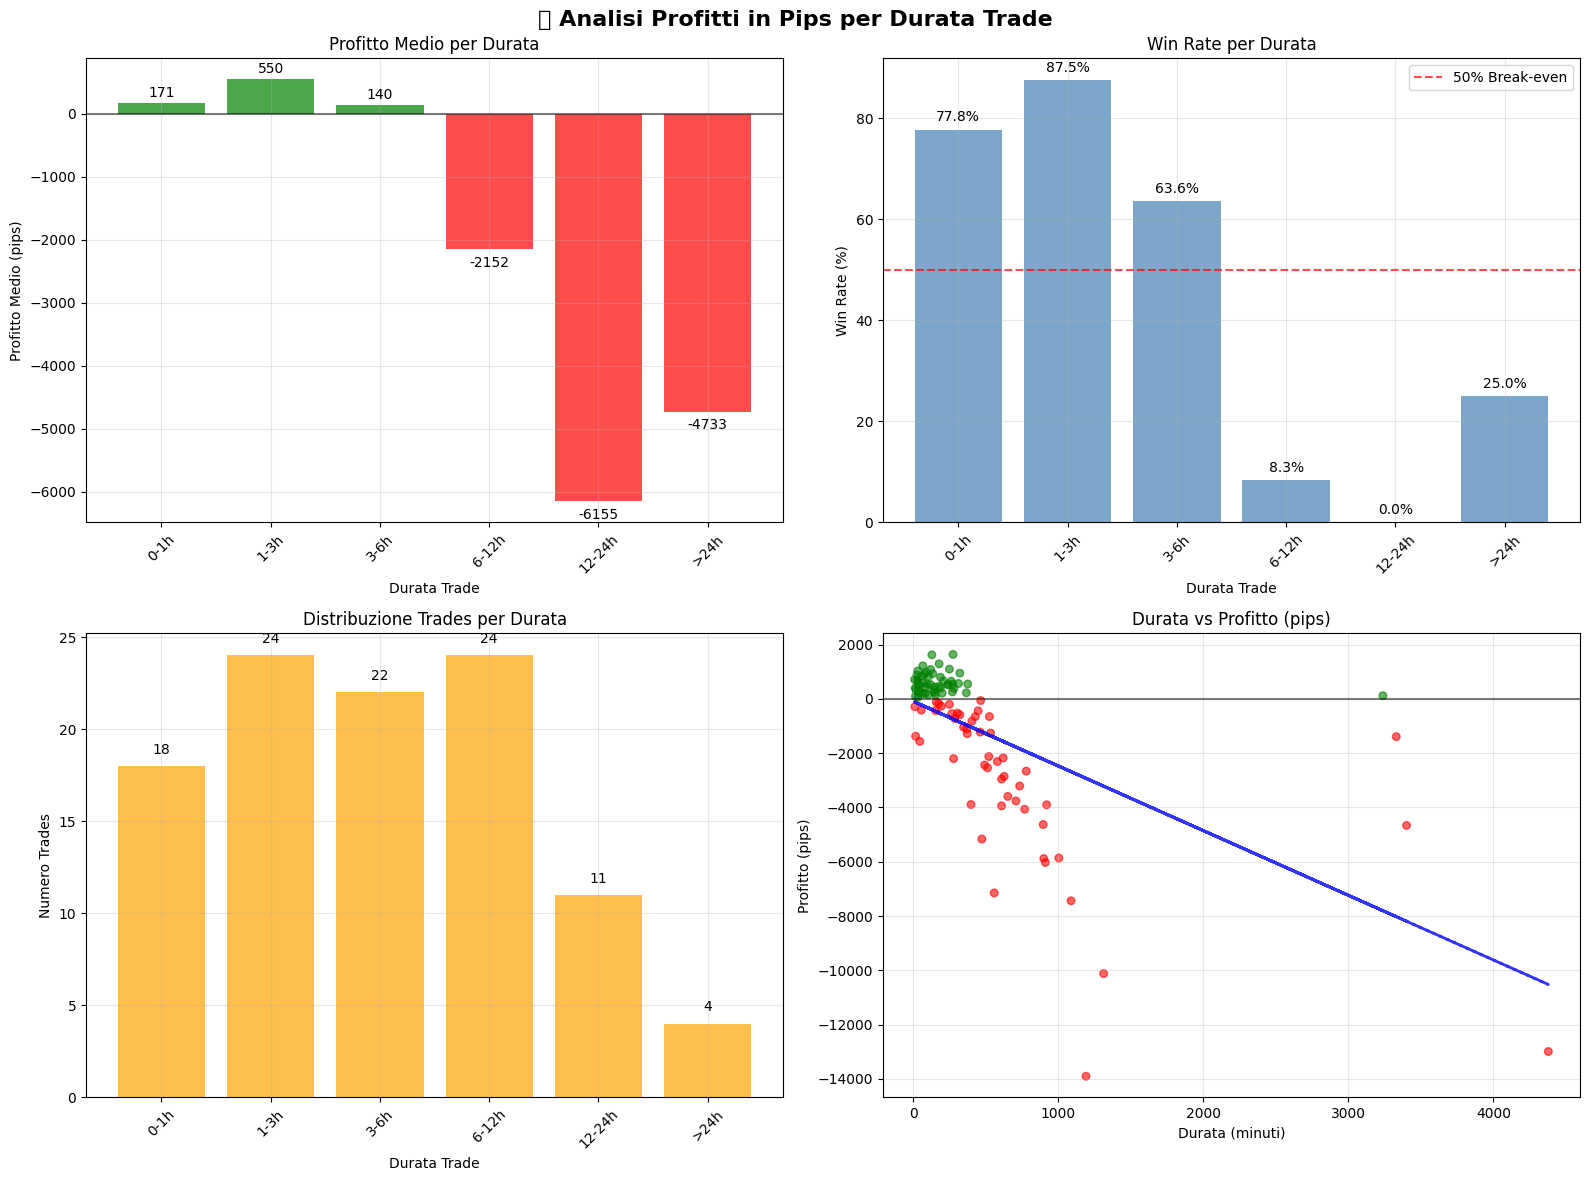

🔗 CORRELAZIONE DURATA-PROFITTO:
   📊 Correlazione: -0.5952
   📊 P-value: 3.35e-11
   🎯 Significatività: Significativa


In [ ]:
def analyze_pips_by_duration(trades_df):
    """Analizza i profitti in pips stratificati per durata"""
    if trades_df is None or len(trades_df) == 0:
        print("❌ No trades data available")
        return
    
    # Convert to pips and add duration in minutes
    pip_value = 0.01
    trades_analysis = trades_df.copy()
    trades_analysis['pnl_pips'] = trades_analysis['pnl'] / pip_value
    trades_analysis['duration_minutes'] = trades_analysis['duration'].dt.total_seconds() / 60
    
    # Create duration bins
    duration_bins = [0, 60, 180, 360, 720, 1440, float('inf')]
    duration_labels = ['0-1h', '1-3h', '3-6h', '6-12h', '12-24h', '>24h']
    trades_analysis['duration_bin'] = pd.cut(trades_analysis['duration_minutes'], 
                                           bins=duration_bins, labels=duration_labels, right=False)
    
    print("⏰ ANALISI PROFITTI PER DURATA TRADE")
    print("=" * 60)
    
    # Analysis by duration bins
    duration_stats = []
    for bin_label in duration_labels:
        bin_data = trades_analysis[trades_analysis['duration_bin'] == bin_label]
        if len(bin_data) > 0:
            win_rate = (bin_data['pnl_pips'] > 0).mean()
            stats_dict = {
                'Duration': bin_label,
                'Count': len(bin_data),
                'Mean_Pips': bin_data['pnl_pips'].mean(),
                'Median_Pips': bin_data['pnl_pips'].median(),
                'Std_Pips': bin_data['pnl_pips'].std(),
                'Win_Rate': win_rate,
                'Best_Trade': bin_data['pnl_pips'].max(),
                'Worst_Trade': bin_data['pnl_pips'].min()
            }
            duration_stats.append(stats_dict)
            
            print(f"📊 {bin_label:>6} ({len(bin_data):2d} trades):")
            print(f"   💰 Media: {bin_data['pnl_pips'].mean():7.1f} pips")
            print(f"   📊 Mediana: {bin_data['pnl_pips'].median():5.1f} pips")
            print(f"   🎯 Win Rate: {win_rate:5.1%}")
            print(f"   📈 Migliore: {bin_data['pnl_pips'].max():6.1f} pips")
            print(f"   📉 Peggiore: {bin_data['pnl_pips'].min():6.1f} pips")
            print()
    
    # Create visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('📊 Analisi Profitti in Pips per Durata Trade', fontsize=16, fontweight='bold')
    
    # 1. Average profit by duration
    duration_df = pd.DataFrame(duration_stats)
    if len(duration_df) > 0:
        bars1 = ax1.bar(duration_df['Duration'], duration_df['Mean_Pips'], 
                       color=['green' if x > 0 else 'red' for x in duration_df['Mean_Pips']], alpha=0.7)
        ax1.axhline(0, color='black', linestyle='-', alpha=0.5)
        ax1.set_xlabel('Durata Trade')
        ax1.set_ylabel('Profitto Medio (pips)')
        ax1.set_title('Profitto Medio per Durata')
        ax1.grid(True, alpha=0.3)
        plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
        
        # Add value labels on bars
        for bar, value in zip(bars1, duration_df['Mean_Pips']):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + (50 if height >= 0 else -100),
                    f'{value:.0f}', ha='center', va='bottom' if height >= 0 else 'top')
    
    # 2. Win rate by duration
    if len(duration_df) > 0:
        bars2 = ax2.bar(duration_df['Duration'], duration_df['Win_Rate'] * 100, 
                       color='steelblue', alpha=0.7)
        ax2.axhline(50, color='red', linestyle='--', alpha=0.7, label='50% Break-even')
        ax2.set_xlabel('Durata Trade')
        ax2.set_ylabel('Win Rate (%)')
        ax2.set_title('Win Rate per Durata')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
        
        # Add value labels
        for bar, value in zip(bars2, duration_df['Win_Rate']):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
                    f'{value:.1%}', ha='center', va='bottom')
    
    # 3. Number of trades by duration
    if len(duration_df) > 0:
        bars3 = ax3.bar(duration_df['Duration'], duration_df['Count'], 
                       color='orange', alpha=0.7)
        ax3.set_xlabel('Durata Trade')
        ax3.set_ylabel('Numero Trades')
        ax3.set_title('Distribuzione Trades per Durata')
        ax3.grid(True, alpha=0.3)
        plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)
        
        # Add value labels
        for bar, value in zip(bars3, duration_df['Count']):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'{int(value)}', ha='center', va='bottom')
    
    # 4. Scatter plot duration vs pips
    duration_minutes = trades_analysis['duration_minutes']
    pips = trades_analysis['pnl_pips']
    colors = ['green' if p > 0 else 'red' for p in pips]
    
    ax4.scatter(duration_minutes, pips, c=colors, alpha=0.6, s=30)
    ax4.axhline(0, color='black', linestyle='-', alpha=0.5)
    ax4.set_xlabel('Durata (minuti)')
    ax4.set_ylabel('Profitto (pips)')
    ax4.set_title('Durata vs Profitto (pips)')
    ax4.grid(True, alpha=0.3)
    
    # Add trendline
    z = np.polyfit(duration_minutes, pips, 1)
    p = np.poly1d(z)
    ax4.plot(duration_minutes, p(duration_minutes), "b--", alpha=0.8, linewidth=2)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate correlation
    correlation, p_value = stats.pearsonr(duration_minutes, pips)
    print(f"🔗 CORRELAZIONE DURATA-PROFITTO:")
    print(f"   📊 Correlazione: {correlation:.4f}")
    print(f"   📊 P-value: {p_value:.2e}")
    print(f"   🎯 Significatività: {'Significativa' if p_value < 0.05 else 'Non significativa'}")
    
    return duration_df

# Execute duration analysis
if 'trades_df_fast' in globals() and trades_df_fast is not None:
    print("⏰ Executing pip analysis by duration...")
    print("=" * 70)
    
    duration_pip_results = analyze_pips_by_duration(trades_df_fast)
else:
    print("❌ No trades data available. Please run the backtest first.")

## 🛑 Backtest con Stop Temporale

Implementiamo una versione migliorata della strategia che include uno stop loss temporale per chiudere automaticamente i trade che durano troppo a lungo.

In [ ]:
# ========================================
# 🛑 CONFIGURAZIONE STOP TEMPORALE
# ========================================

# 📋 Configura qui il limite temporale (in minuti)
MAX_TRADE_DURATION_MINUTES = 20  # 6 ore = 360 minuti
                                   # Modifica questo valore per testare diversi timeout

print(f"🛑 STOP TEMPORALE CONFIGURATO:")
print(f"   ⏰ Durata massima trade: {MAX_TRADE_DURATION_MINUTES} minuti ({MAX_TRADE_DURATION_MINUTES/60:.1f} ore)")
print(f"   🎯 Trade che durano più di {MAX_TRADE_DURATION_MINUTES} minuti verranno chiusi automaticamente")
print("=" * 70)

🛑 STOP TEMPORALE CONFIGURATO:
   ⏰ Durata massima trade: 20 minuti (0.3 ore)
   🎯 Trade che durano più di 20 minuti verranno chiusi automaticamente


In [ ]:
@jit(nopython=True)
def bollinger_strategy_with_time_stop(ask_prices, bid_prices, close_prices, upper_bands, middle_bands, lower_bands, 
                                     timestamps, initial_capital, max_duration_minutes):
    """Strategia Bollinger Bands con stop temporale - evita repaint usando prezzi correnti"""
    n = len(close_prices)
    max_trades = 10000
    
    # Pre-allocate trade arrays
    entry_indices = np.zeros(max_trades, dtype=np.int64)
    exit_indices = np.zeros(max_trades, dtype=np.int64)
    positions = np.zeros(max_trades, dtype=np.int64)
    entry_prices = np.zeros(max_trades, dtype=np.float64)
    exit_prices = np.zeros(max_trades, dtype=np.float64)
    pnls = np.zeros(max_trades, dtype=np.float64)
    position_sizes = np.zeros(max_trades, dtype=np.float64)
    equities = np.zeros(max_trades, dtype=np.float64)
    exit_reasons = np.zeros(max_trades, dtype=np.int64)  # 1=middle_band, 2=time_stop
    
    trade_count = 0
    position = 0
    entry_price = 0.0
    entry_idx = 0
    entry_timestamp = 0.0
    current_equity = initial_capital
    position_size = 0.0
    max_duration_ns = max_duration_minutes * 60 * 1_000_000_000  # Convert to nanoseconds
    
    for i in range(1, n):
        # Use current close/bands for signals (no look-ahead)
        current_close = close_prices[i]
        current_upper = upper_bands[i]
        current_middle = middle_bands[i]
        current_lower = lower_bands[i]
        current_timestamp = timestamps[i]
        
        if np.isnan(current_upper) or np.isnan(current_middle) or np.isnan(current_lower):
            continue
            
        current_ask = ask_prices[i]
        current_bid = bid_prices[i]
        
        # Check if we have an open position
        if position != 0:
            # Calculate duration of current trade
            trade_duration_ns = current_timestamp - entry_timestamp
            
            # Check exit conditions
            should_exit_middle = False
            should_exit_time = False
            
            # Exit at middle band (original condition)
            if position == 1 and current_close >= current_middle:
                should_exit_middle = True
            elif position == -1 and current_close <= current_middle:
                should_exit_middle = True
            
            # Exit due to time limit
            if trade_duration_ns >= max_duration_ns:
                should_exit_time = True
            
            # Execute exit if any condition is met
            if should_exit_middle or should_exit_time:
                # Realistic spread handling - use CURRENT prices for exit
                if position == 1:  # Long position - sell at current bid
                    exit_price = current_bid
                    pnl = (exit_price - entry_price) * position_size
                else:  # Short position - buy at current ask
                    exit_price = current_ask
                    pnl = (entry_price - exit_price) * position_size
                
                # Update equity
                current_equity += pnl
                
                # Record trade
                if trade_count < max_trades:
                    entry_indices[trade_count] = entry_idx
                    exit_indices[trade_count] = i
                    positions[trade_count] = position
                    entry_prices[trade_count] = entry_price
                    exit_prices[trade_count] = exit_price
                    pnls[trade_count] = pnl
                    position_sizes[trade_count] = position_size
                    equities[trade_count] = current_equity
                    exit_reasons[trade_count] = 1 if should_exit_middle else 2
                    trade_count += 1
                
                # Reset position
                position = 0
                position_size = 0.0
        
        # Open new position (only if no current position and equity > 0)
        if position == 0 and current_equity > 0:
            if current_close < current_lower:  # BUY signal
                position = 1
                entry_price = current_ask  # Buy at ask (pay spread)
                position_size = current_equity / current_ask  # Use all equity
                entry_idx = i
                entry_timestamp = current_timestamp
            elif current_close > current_upper:  # SELL signal
                position = -1
                entry_price = current_bid  # Sell at bid (pay spread)
                position_size = current_equity / current_bid  # Use all equity equivalent
                entry_idx = i
                entry_timestamp = current_timestamp
    
    return (entry_indices[:trade_count], exit_indices[:trade_count], 
            positions[:trade_count], entry_prices[:trade_count], 
            exit_prices[:trade_count], pnls[:trade_count],
            position_sizes[:trade_count], equities[:trade_count],
            exit_reasons[:trade_count])

def run_backtest_with_time_stop(tick_data_path=TICK_DATA_PATH, bb_window=BB_WINDOW, bb_std=BB_STD, 
                               initial_capital=INITIAL_CAPITAL, max_duration_minutes=MAX_TRADE_DURATION_MINUTES):
    """Esegue backtest con stop temporale"""
    print(f"🚀 Avvio backtest con stop temporale...")
    print(f"   ⏰ Durata massima: {max_duration_minutes} minuti")
    print(f"   📊 BB Window: {bb_window}, Std: {bb_std}")
    print("=" * 50)
    
    # Load and process data
    df_ticks = pd.read_csv(tick_data_path)
    df_ticks['timestamp'] = pd.to_datetime(df_ticks['timestamp'])
    df_ticks = df_ticks.sort_values('timestamp').reset_index(drop=True)
    
    # Create 1-minute OHLC
    df_ticks_indexed = df_ticks.set_index('timestamp')
    df_ticks_indexed['mid_price'] = (df_ticks_indexed['askPrice'] + df_ticks_indexed['bidPrice']) / 2
    
    df_1min = df_ticks_indexed['mid_price'].resample('1min').ohlc()
    df_1min.reset_index(inplace=True)
    df_1min.columns = ['timestamp', 'open', 'high', 'low', 'close']
    df_1min = df_1min.dropna().reset_index(drop=True)
    
    # Calculate Bollinger Bands and map signals
    df_1min = calculate_bollinger_bands(df_1min, 'close', bb_window, bb_std)
    df_1min_signals = df_1min[['timestamp', 'close', 'upper_band', 'middle_band', 'lower_band']].dropna()
    
    df_merged = pd.merge_asof(
        df_ticks[['timestamp', 'askPrice', 'bidPrice']].sort_values('timestamp'),
        df_1min_signals.sort_values('timestamp'),
        on='timestamp', direction='backward'
    )
    
    # Convert timestamps to int64 for numba
    timestamps_ns = df_merged['timestamp'].astype('int64').values
    
    # Execute strategy with time stop
    start_time = time.time()
    result = bollinger_strategy_with_time_stop(
        df_merged['askPrice'].values, df_merged['bidPrice'].values, df_merged['close'].values,
        df_merged['upper_band'].values, df_merged['middle_band'].values, df_merged['lower_band'].values,
        timestamps_ns, initial_capital, max_duration_minutes
    )
    execution_time = time.time() - start_time
    
    entry_indices, exit_indices, positions, entry_prices, exit_prices, pnls, position_sizes, equities, exit_reasons = result
    
    if len(entry_indices) > 0:
        trades_df = pd.DataFrame({
            'entry_time': df_merged['timestamp'].values[entry_indices],
            'exit_time': df_merged['timestamp'].values[exit_indices],
            'position': positions,
            'entry_price': entry_prices,
            'exit_price': exit_prices,
            'pnl': pnls,
            'position_size': position_sizes,
            'equity_after_trade': equities,
            'exit_reason': exit_reasons  # 1=middle_band, 2=time_stop
        })
        trades_df['duration'] = trades_df['exit_time'] - trades_df['entry_time']
        trades_df['duration_minutes'] = trades_df['duration'].dt.total_seconds() / 60
        trades_df['return_pct'] = trades_df['pnl'] / (trades_df['equity_after_trade'] - trades_df['pnl']) * 100
        
        # Add exit reason labels
        trades_df['exit_reason_label'] = trades_df['exit_reason'].map({1: 'Middle_Band', 2: 'Time_Stop'})
        
        print(f"✅ Backtest completato in {execution_time:.2f}s")
        return trades_df, df_1min
    else:
        print("❌ Nessun trade eseguito")
        return None, df_1min

print("🛑 Funzioni per stop temporale definite correttamente")

🛑 Funzioni per stop temporale definite correttamente


In [ ]:
# ========================================
# 🚀 ESECUZIONE BACKTEST CON STOP TEMPORALE
# ========================================

# Esegui il backtest con stop temporale
trades_df_time_stop, df_1min_time_stop = run_backtest_with_time_stop(
    max_duration_minutes=MAX_TRADE_DURATION_MINUTES
)

# Mostra risultati
if trades_df_time_stop is not None:
    print(f"\n🎯 RISULTATI BACKTEST CON STOP TEMPORALE:")
    print("=" * 60)
    print(f"📊 Totale Trade: {len(trades_df_time_stop)}")
    print(f"💰 PnL Totale: ${trades_df_time_stop['pnl'].sum():.2f}")
    print(f"📈 Return Totale: {((trades_df_time_stop['equity_after_trade'].iloc[-1] / INITIAL_CAPITAL) - 1) * 100:.2f}%")
    print(f"🎯 Win Rate: {(trades_df_time_stop['pnl'] > 0).mean():.1%}")
    print(f"💰 Equity Finale: ${trades_df_time_stop['equity_after_trade'].iloc[-1]:,.2f}")
    print(f"⏱️ Durata Media: {trades_df_time_stop['duration_minutes'].mean():.1f} minuti")
    
    # Analisi per tipo di uscita
    exit_stats = trades_df_time_stop['exit_reason_label'].value_counts()
    print(f"\n📊 ANALISI TIPI DI USCITA:")
    for reason, count in exit_stats.items():
        pct = count / len(trades_df_time_stop) * 100
        reason_trades = trades_df_time_stop[trades_df_time_stop['exit_reason_label'] == reason]
        avg_pnl = reason_trades['pnl'].mean()
        win_rate = (reason_trades['pnl'] > 0).mean()
        print(f"   {reason:>12}: {count:3d} trades ({pct:4.1f}%) - PnL medio: ${avg_pnl:8.2f} - Win Rate: {win_rate:5.1%}")
    
    print(f"\n⏰ STATISTICHE DURATA:")
    print(f"   📏 Min: {trades_df_time_stop['duration_minutes'].min():.1f} minuti")
    print(f"   📏 Max: {trades_df_time_stop['duration_minutes'].max():.1f} minuti")
    print(f"   📊 Media: {trades_df_time_stop['duration_minutes'].mean():.1f} minuti")
    print(f"   📊 Mediana: {trades_df_time_stop['duration_minutes'].median():.1f} minuti")
    
    # Confronto con strategia originale
    if 'trades_df_fast' in globals() and trades_df_fast is not None:
        print(f"\n📈 CONFRONTO CON STRATEGIA ORIGINALE:")
        print("=" * 60)
        original_return = ((trades_df_fast['equity_after_trade'].iloc[-1] / INITIAL_CAPITAL) - 1) * 100
        time_stop_return = ((trades_df_time_stop['equity_after_trade'].iloc[-1] / INITIAL_CAPITAL) - 1) * 100
        improvement = time_stop_return - original_return
        
        print(f"{'Metrica':<20} {'Originale':<15} {'Con Stop':<15} {'Miglioramento':<15}")
        print("-" * 65)
        print(f"{'Return Totale %':<20} {original_return:<15.2f} {time_stop_return:<15.2f} {improvement:<15.2f}")
        print(f"{'Numero Trade':<20} {len(trades_df_fast):<15} {len(trades_df_time_stop):<15} {len(trades_df_time_stop)-len(trades_df_fast):<15}")
        print(f"{'Win Rate %':<20} {(trades_df_fast['pnl'] > 0).mean()*100:<15.1f} {(trades_df_time_stop['pnl'] > 0).mean()*100:<15.1f} {((trades_df_time_stop['pnl'] > 0).mean()-(trades_df_fast['pnl'] > 0).mean())*100:<15.1f}")
        print(f"{'Durata Media (min)':<20} {trades_df_fast['duration'].dt.total_seconds().mean()/60:<15.1f} {trades_df_time_stop['duration_minutes'].mean():<15.1f} {trades_df_time_stop['duration_minutes'].mean() - trades_df_fast['duration'].dt.total_seconds().mean()/60:<15.1f}")
else:
    print("❌ Nessun trade eseguito con stop temporale")

🚀 Avvio backtest con stop temporale...
   ⏰ Durata massima: 20 minuti
   📊 BB Window: 600, Std: 2
✅ Backtest completato in 0.47s

🎯 RISULTATI BACKTEST CON STOP TEMPORALE:
📊 Totale Trade: 598
💰 PnL Totale: $-1788.93
📈 Return Totale: -17.89%
🎯 Win Rate: 34.8%
💰 Equity Finale: $8,211.07
⏱️ Durata Media: 24.7 minuti

📊 ANALISI TIPI DI USCITA:
      Time_Stop: 588 trades (98.3%) - PnL medio: $   -3.07 - Win Rate: 34.2%
    Middle_Band:  10 trades ( 1.7%) - PnL medio: $    1.91 - Win Rate: 70.0%

⏰ STATISTICHE DURATA:
   📏 Min: 8.0 minuti
   📏 Max: 2890.0 minuti
   📊 Media: 24.7 minuti
   📊 Mediana: 20.0 minuti

📈 CONFRONTO CON STRATEGIA ORIGINALE:
Metrica              Originale       Con Stop        Miglioramento  
-----------------------------------------------------------------
Return Totale %      -11.89          -17.89          -6.00          
Numero Trade         103             598             495            
Win Rate %           50.5            34.8            -15.7          
Durata 

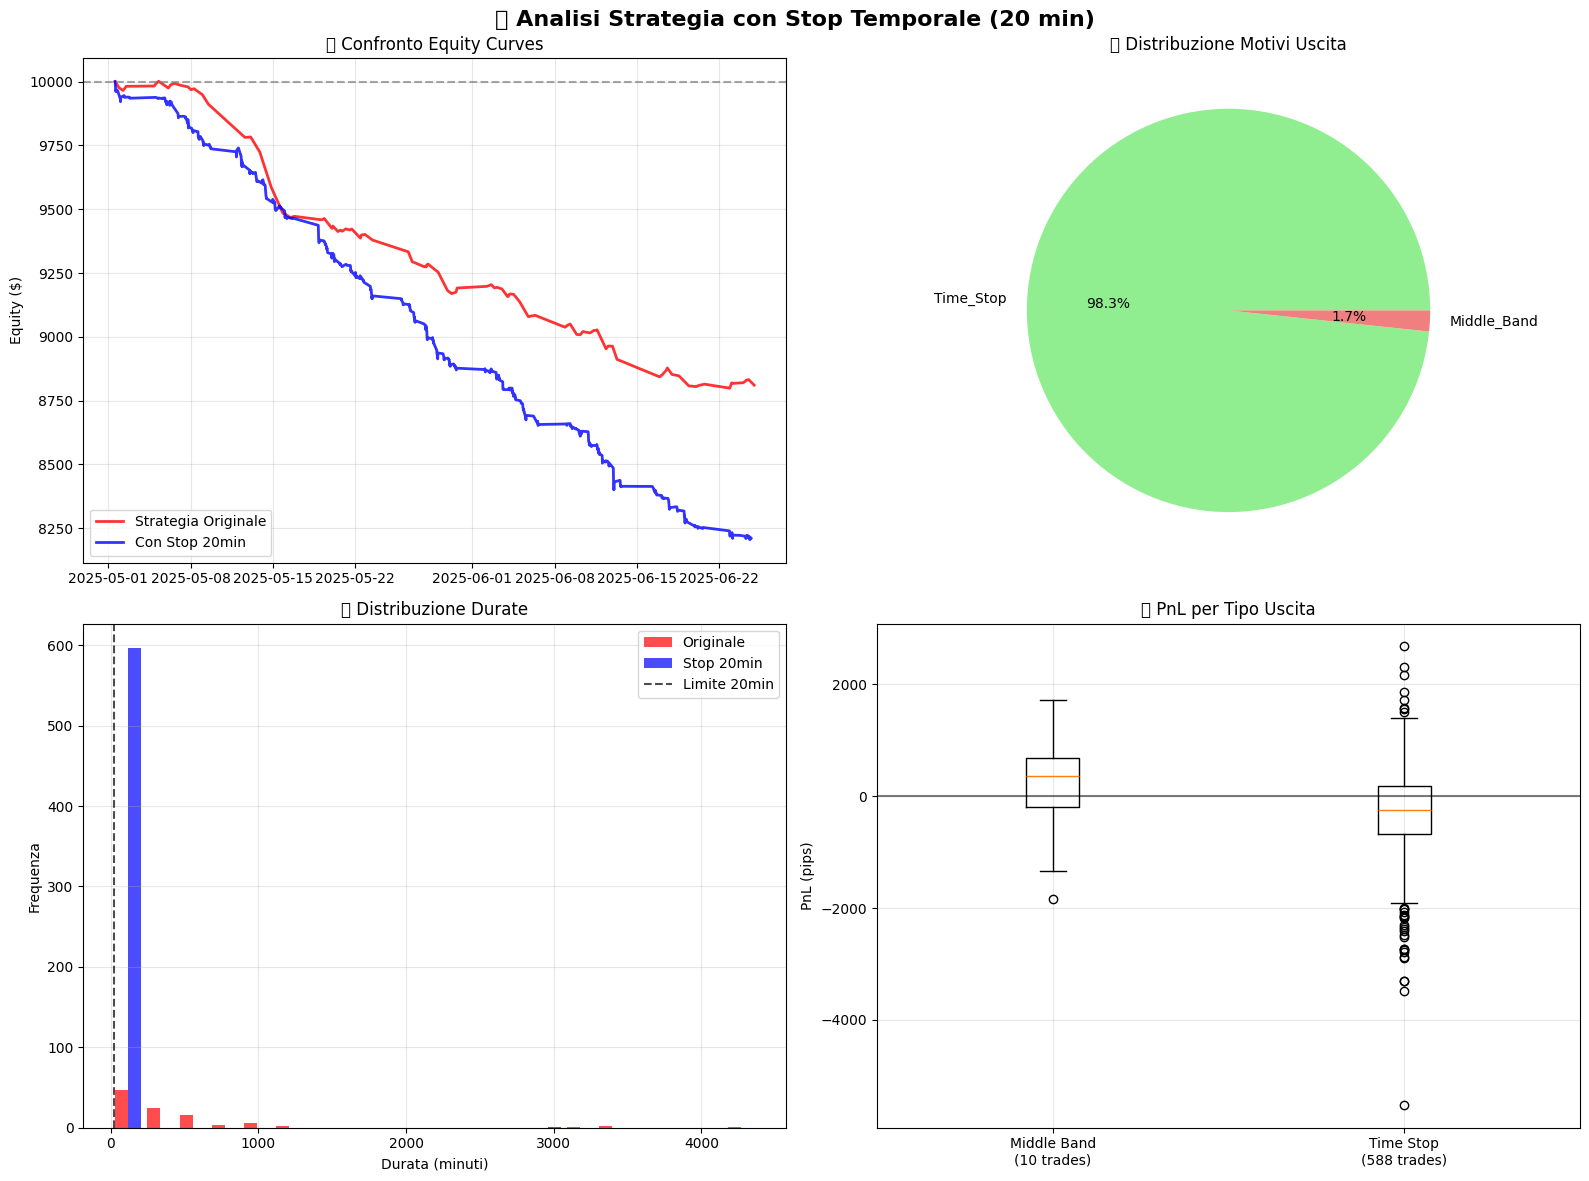


📈 ANALISI DETTAGLIATA STOP TEMPORALE:
✅ USCITE AL MIDDLE BAND (10 trades):
   💰 PnL medio: 190.5 pips
   🎯 Win Rate: 70.0%
   ⏱️ Durata media: 13.9 minuti
   📊 Best: 1718.8 pips
   📊 Worst: -1834.1 pips

⏰ USCITE PER STOP TEMPORALE (588 trades):
   💰 PnL medio: -307.5 pips
   🎯 Win Rate: 34.2%
   ⏱️ Durata media: 24.9 minuti
   📊 Best: 2677.4 pips
   📊 Worst: -5516.1 pips

🎯 MIGLIORAMENTO COMPLESSIVO:
   💰 Differenza Equity: $-599.65
   📈 Miglioramento %: -6.81%


In [ ]:
def plot_time_stop_analysis(trades_df_original, trades_df_time_stop, max_duration_minutes):
    """Confronta visualmente i risultati delle due strategie"""
    if trades_df_time_stop is None:
        print("❌ No time-stop trades to plot")
        return
    
    # Convert pips
    pip_value = 0.01
    trades_df_time_stop = trades_df_time_stop.copy()
    trades_df_time_stop['pnl_pips'] = trades_df_time_stop['pnl'] / pip_value
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'📊 Analisi Strategia con Stop Temporale ({max_duration_minutes} min)', fontsize=16, fontweight='bold')
    
    # 1. Equity curves comparison
    if trades_df_original is not None:
        # Original equity curve
        equity_orig = [INITIAL_CAPITAL] + trades_df_original['equity_after_trade'].tolist()
        time_orig = [trades_df_original['entry_time'].iloc[0]] + trades_df_original['exit_time'].tolist()
        ax1.plot(time_orig, equity_orig, 'r-', alpha=0.8, linewidth=2, label='Strategia Originale')
    
    # Time-stop equity curve
    equity_stop = [INITIAL_CAPITAL] + trades_df_time_stop['equity_after_trade'].tolist()
    time_stop = [trades_df_time_stop['entry_time'].iloc[0]] + trades_df_time_stop['exit_time'].tolist()
    ax1.plot(time_stop, equity_stop, 'b-', alpha=0.8, linewidth=2, label=f'Con Stop {max_duration_minutes}min')
    
    ax1.axhline(INITIAL_CAPITAL, color='gray', linestyle='--', alpha=0.7)
    ax1.set_title('💰 Confronto Equity Curves')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylabel('Equity ($)')
    
    # 2. Exit reasons distribution
    exit_counts = trades_df_time_stop['exit_reason_label'].value_counts()
    colors = ['lightgreen', 'lightcoral']
    ax2.pie(exit_counts.values, labels=exit_counts.index, autopct='%1.1f%%', colors=colors)
    ax2.set_title('🎯 Distribuzione Motivi Uscita')
    
    # 3. Duration comparison
    if trades_df_original is not None:
        orig_durations = trades_df_original['duration'].dt.total_seconds() / 60
        ax3.hist([orig_durations, trades_df_time_stop['duration_minutes']], 
                bins=20, alpha=0.7, color=['red', 'blue'], 
                label=['Originale', f'Stop {max_duration_minutes}min'])
        ax3.axvline(max_duration_minutes, color='black', linestyle='--', alpha=0.7, label=f'Limite {max_duration_minutes}min')
    else:
        ax3.hist(trades_df_time_stop['duration_minutes'], bins=20, alpha=0.7, color='blue')
    
    ax3.set_xlabel('Durata (minuti)')
    ax3.set_ylabel('Frequenza')
    ax3.set_title('⏱️ Distribuzione Durate')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. PnL by exit reason
    middle_band_trades = trades_df_time_stop[trades_df_time_stop['exit_reason_label'] == 'Middle_Band']['pnl_pips']
    time_stop_trades = trades_df_time_stop[trades_df_time_stop['exit_reason_label'] == 'Time_Stop']['pnl_pips']
    
    box_data = []
    labels = []
    if len(middle_band_trades) > 0:
        box_data.append(middle_band_trades)
        labels.append(f'Middle Band\n({len(middle_band_trades)} trades)')
    if len(time_stop_trades) > 0:
        box_data.append(time_stop_trades)
        labels.append(f'Time Stop\n({len(time_stop_trades)} trades)')
    
    if box_data:
        ax4.boxplot(box_data, labels=labels)
        ax4.axhline(0, color='black', linestyle='-', alpha=0.5)
        ax4.set_ylabel('PnL (pips)')
        ax4.set_title('📊 PnL per Tipo Uscita')
        ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Detailed analysis
    print(f"\n📈 ANALISI DETTAGLIATA STOP TEMPORALE:")
    print("=" * 60)
    
    # Middle band exits
    mb_trades = trades_df_time_stop[trades_df_time_stop['exit_reason_label'] == 'Middle_Band']
    if len(mb_trades) > 0:
        print(f"✅ USCITE AL MIDDLE BAND ({len(mb_trades)} trades):")
        print(f"   💰 PnL medio: {mb_trades['pnl_pips'].mean():.1f} pips")
        print(f"   🎯 Win Rate: {(mb_trades['pnl_pips'] > 0).mean():.1%}")
        print(f"   ⏱️ Durata media: {mb_trades['duration_minutes'].mean():.1f} minuti")
        print(f"   📊 Best: {mb_trades['pnl_pips'].max():.1f} pips")
        print(f"   📊 Worst: {mb_trades['pnl_pips'].min():.1f} pips")
        print()
    
    # Time stop exits
    ts_trades = trades_df_time_stop[trades_df_time_stop['exit_reason_label'] == 'Time_Stop']
    if len(ts_trades) > 0:
        print(f"⏰ USCITE PER STOP TEMPORALE ({len(ts_trades)} trades):")
        print(f"   💰 PnL medio: {ts_trades['pnl_pips'].mean():.1f} pips")
        print(f"   🎯 Win Rate: {(ts_trades['pnl_pips'] > 0).mean():.1%}")
        print(f"   ⏱️ Durata media: {ts_trades['duration_minutes'].mean():.1f} minuti")
        print(f"   📊 Best: {ts_trades['pnl_pips'].max():.1f} pips")
        print(f"   📊 Worst: {ts_trades['pnl_pips'].min():.1f} pips")
        print()
    
    # Calculate improvement
    original_final = trades_df_original['equity_after_trade'].iloc[-1] if trades_df_original is not None else INITIAL_CAPITAL
    time_stop_final = trades_df_time_stop['equity_after_trade'].iloc[-1]
    
    improvement_dollars = time_stop_final - original_final
    improvement_pct = (improvement_dollars / original_final) * 100 if original_final != 0 else 0
    
    print(f"🎯 MIGLIORAMENTO COMPLESSIVO:")
    print(f"   💰 Differenza Equity: ${improvement_dollars:.2f}")
    print(f"   📈 Miglioramento %: {improvement_pct:.2f}%")

# Execute visualization
if 'trades_df_time_stop' in locals() and trades_df_time_stop is not None:
    plot_time_stop_analysis(trades_df_fast, trades_df_time_stop, MAX_TRADE_DURATION_MINUTES)

## 🔬 Sperimentazione Stop Temporale

Usa la cella seguente per testare rapidamente diversi valori di stop temporale modificando il parametro `TEST_DURATION_MINUTES`.

In [ ]:
# ========================================
# 🔬 TEST RAPIDO DIVERSI STOP TEMPORALI
# ========================================

# 🎯 MODIFICA QUESTO VALORE PER TESTARE DIVERSI STOP TEMPORALI
TEST_DURATION_MINUTES = 240  # Prova con 4 ore (240 minuti)
                              # Altri valori da testare: 120, 180, 240, 300, 480, 720

print(f"🔬 Testing stop temporale a {TEST_DURATION_MINUTES} minuti ({TEST_DURATION_MINUTES/60:.1f} ore)")
print("=" * 70)

# Esegui backtest rapido
test_trades, _ = run_backtest_with_time_stop(max_duration_minutes=TEST_DURATION_MINUTES)

if test_trades is not None:
    # Calcola metriche chiave
    total_return = ((test_trades['equity_after_trade'].iloc[-1] / INITIAL_CAPITAL) - 1) * 100
    win_rate = (test_trades['pnl'] > 0).mean()
    avg_duration = test_trades['duration_minutes'].mean()
    
    # Analisi per tipo di uscita
    exit_stats = test_trades['exit_reason_label'].value_counts()
    middle_band_pct = (exit_stats.get('Middle_Band', 0) / len(test_trades)) * 100
    time_stop_pct = (exit_stats.get('Time_Stop', 0) / len(test_trades)) * 100
    
    # Confronto con originale
    if 'trades_df_fast' in globals() and trades_df_fast is not None:
        original_return = ((trades_df_fast['equity_after_trade'].iloc[-1] / INITIAL_CAPITAL) - 1) * 100
        improvement = total_return - original_return
        
        print(f"📊 RISULTATI STOP {TEST_DURATION_MINUTES} MINUTI:")
        print(f"   📈 Return: {total_return:.2f}% (originale: {original_return:.2f}%) → Miglioramento: {improvement:.2f}%")
        print(f"   🎯 Win Rate: {win_rate:.1%}")
        print(f"   📊 Trade Totali: {len(test_trades)}")
        print(f"   ⏱️ Durata Media: {avg_duration:.1f} minuti")
        print(f"   🎯 Middle Band: {middle_band_pct:.1f}% | Time Stop: {time_stop_pct:.1f}%")
        
        # Valutazione
        if improvement > 1:
            print(f"   ✅ BUONO: Miglioramento significativo (+{improvement:.2f}%)")
        elif improvement > 0:
            print(f"   🟡 MODERATO: Leggero miglioramento (+{improvement:.2f}%)")
        else:
            print(f"   ❌ PEGGIORAMENTO: ({improvement:.2f}%)")
    
    print(f"\n💡 Per testare altri valori, modifica TEST_DURATION_MINUTES sopra ed esegui nuovamente")
    print(f"   Valori suggeriti: 120 (2h), 180 (3h), 240 (4h), 300 (5h), 480 (8h), 720 (12h)")
else:
    print("❌ Nessun trade eseguito con questo stop temporale")

🔬 Testing stop temporale a 240 minuti (4.0 ore)
🚀 Avvio backtest con stop temporale...
   ⏰ Durata massima: 240 minuti
   📊 BB Window: 600, Std: 2
✅ Backtest completato in 0.01s
📊 RISULTATI STOP 240 MINUTI:
   📈 Return: -9.91% (originale: -11.89%) → Miglioramento: 1.98%
   🎯 Win Rate: 45.8%
   📊 Trade Totali: 144
   ⏱️ Durata Media: 217.0 minuti
   🎯 Middle Band: 43.8% | Time Stop: 56.2%
   ✅ BUONO: Miglioramento significativo (+1.98%)

💡 Per testare altri valori, modifica TEST_DURATION_MINUTES sopra ed esegui nuovamente
   Valori suggeriti: 120 (2h), 180 (3h), 240 (4h), 300 (5h), 480 (8h), 720 (12h)
